# Finding the best generalized ML model to predict recall from EEG data

## Imports and Helper Functions

In [125]:
%%capture --no-display

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cmlreaders import CMLReader, get_data_index
import xarray as xr
import datetime
import traceback
import netCDF4 as nc
import functools
from scipy import stats
from itertools import chain
import math

import warnings
warnings.filterwarnings('ignore')

from ptsa.data.filters import morlet
from ptsa.data.filters import ButterworthFilter

import cmldask.CMLDask as da
import cmldask
from dask.distributed import wait, as_completed, progress

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, classification_report, plot_confusion_matrix

In [83]:
def pickle_save(filename, item_to_load):
    import pickle 
    with open ((filename+'.pkl'), 'wb') as f:
        pickle.dump(item_to_load, f)
        
def pickle_load(filename):
    import pickle 
    with open ((filename+'.pkl'), 'rb') as f:
        deserialized = pickle.load(f)
    return deserialized

## Retrieving Training and Testing Subjects

We want to find the subjects with the minimum number of electrodes (16 in the temporal region, 8 in the frontal region, and 2 in the hippocampal region) in each brain region.

In [217]:
# get list of all subjects
subjects = []
df = get_data_index('all')
df = df[((df['experiment']=='FR1') | (df['experiment']=='catFR1'))]
for df_sess in df.itertuples():
    df_sess = df_sess._asdict()
    subjects.append(df_sess['subject'])
all_subs = list(set(subjects))

In [ ]:
# get count of electrodes for each brain region for each subject
sub_electrode_count = {}
locations = ["temporal", "frontal", "hippocampal"]
for sub in all_subs:
    df = get_data_index('all')
    df = df[(df['subject']==sub) & ((df['experiment']=='FR1') | (df['experiment']=='catFR1'))]
    for df_sess in df.head(1).itertuples():
        try:
            # prepare the reader and load EEG
            df_sess = df_sess._asdict()
            reader = CMLReader(df_sess['subject'], df_sess['experiment'], df_sess['session'], df_sess['montage'], df_sess['localization'])
            evs = reader.load('events')
            enc_evs = evs[evs.type=='WORD']
            scheme = reader.load('pairs')
            eeg = reader.load_eeg(events=enc_evs, rel_start=-1000, rel_stop=2600, clean=True, scheme=scheme)

            if len(eeg.events) != enc_evs.shape[0]:
                raise IndexError(str(len(eeg.events)) + ' eeg events for ' + str(enc_evs.shape[0]) + ' encoding events')

            sr = eeg.samplerate
            eeg_ptsa = eeg.to_ptsa()

            channels = eeg_ptsa.channel.values
        except Exception as e:
            print(df_sess['subject'], e)
            continue
    
        try:
            electrode_count = {}
            for loc_index in range(len(locations)):
                loc = locations[loc_index]
                loc_filter = [loc in s for s in [s if s else '' for s in scheme.iloc()[:]['ind.region']]]
                eeg_chan_loc = eeg_ptsa[:,loc_filter,:]
                electrode_count[loc] = len(eeg_chan_loc[0])
        except Exception as e:
            print(df_sess['subject'], e)
            electrode_count = {
                "temporal": 0,
                "frontal": 0,
                "hippocampal": 0}
        sub_electrode_count[sub] = electrode_count

In [ ]:
sub_electrode_count_full_df = pd.DataFrame.from_dict(sub_electrode_count).transpose()
pickle_save("sub_electrode_full_counts", sub_electrode_count_full_df)

In [71]:
sub_electrode_count_df = pickle_load("sub_electrode_full_counts")
sub_electrode_count_df = sub_electrode_count_df.loc[~(sub_electrode_count_df==0).all(axis=1)]
sub_electrode_count_df = sub_electrode_count_df[sub_electrode_count_df["temporal"] > 16]
sub_electrode_count_df = sub_electrode_count_df[sub_electrode_count_df["frontal"] > 8]
sub_electrode_count_df = sub_electrode_count_df[sub_electrode_count_df["hippocampal"] > 2]
print("Number of subjects to split into testing and training: ", len(sub_electrode_count_df.index))
pickle_save('sub_electrode_counts', sub_electrode_count_df)

Number of subjects to split into testing and training:  48


### Split Subjects into Train and Test Data

In [42]:
subs_df = pickle_load('sub_electrode_counts')
all_model_subs = list(subs_df.index)

In [43]:
# split into test and train subjects
train_subs = all_model_subs[::2]
test_subs = all_model_subs[1::2]

# drop subjects that give errors upon loading
train_subs.remove("R1063C")
train_subs.remove("R1191J")
train_subs.remove("R1486J")

print("Training subjects: ", train_subs)
print("Testing subjects: ", test_subs)

Training subjects:  ['R1089P', 'R1288P', 'R1674A', 'R1422T', 'R1123C', 'R1364C', 'R1376D', 'R1646T', 'R1236J', 'R1436J', 'R1415T', 'R1616S', 'R1420T', 'R1059J', 'R1337E', 'R1171M', 'R1157C', 'R1515T', 'R1468J', 'R1640T', 'R1473J']
Testing subjects:  ['R1086M', 'R1153T', 'R1299T', 'R1537T', 'R1030J', 'R1217T', 'R1379E', 'R1617S', 'R1316T', 'R1372C', 'R1070T', 'R1391T', 'R1571T', 'R1627T', 'R1573T', 'R1366J', 'R1378T', 'R1144E', 'R1668S', 'R1203T', 'R1361C', 'R1569T', 'R1266J', 'R1186P']


## Generate Features

### Helper Functions

In [79]:
# only includes specified number of electrodes in from each region
def crop_loc_powers(loc_powers, loc, temp_count, front_count, hippo_count):
    crop_index = 0
    if (loc == "temporal"):
        crop_index = temp_count
    elif (loc == "frontal"):
        crop_index = front_count
    elif (loc == "hippocampal"):
        crop_index = hippo_count

    new_powers = []
    for x in loc_powers:
        new_x = []
        for y in x:
            new_y = y[:crop_index]
            new_x.append(new_y)
        new_powers.append(new_x)
    return new_powers

In [80]:
def reshape_session_powers(powers):
    new_powers = []
    for i in range(8):
        freq = []
        freq_temp = powers[i]
        freq_front = powers[i+8]
        freq_hippo = powers[i+16]
        for j in range(len(freq_temp)):
            val = list(freq_temp[j])
            val.extend(list(freq_front[j]))
            val.extend(list(freq_hippo[j]))
            freq.append(val)
        new_powers.append(freq)
    return new_powers

In [81]:
# before reshaping:
# len(powers) is the number of sessions for a subject (A)
# len(powers[0]) is 8, we have 8 frequencies for a session
# len(powers[0][0]) is the number of encoding events (B)
# len(powers[0][0][0]) is 26, we have 26 electrodes that we'll look at

# there are (encoding events * sessions) rows, and a column is unique frequency x channel pairing
# in feature matrix, there are A * B rows and 8 * 26 columns

def reshape_subject_powers(subj_powers):
    matrix = []
    sess_count = 0
    for session in subj_powers:
        sess_count += 1
        freq_count = 0
        freqs = {}
        for freq in session:
            freq_count += 1
            events_count = 0
            events = {}
            for enc_evs in freq:
                events_count += 1
                events['event ' + str(events_count)] = enc_evs
            freqs['freq ' + str(freq_count)] = events

        for events_k in events.keys():
            row = []
            for freqs_k in freqs.keys():
                row.append(freqs[freqs_k][events_k])
            flattened_row = list(chain.from_iterable(row))
            matrix.append(flattened_row)
    del subj_powers
    return matrix

### Compute Powers

In [224]:
locations = ['temporal', 'frontal', 'hippocampal']
def generateFeatures(subj):
    logfile = f'{subj}_log.txt'
    subj_powers = []
    y_matrix = []

    df = get_data_index('all')
    df = df[(df['subject']==subj) & ((df['experiment']=='FR1') | (df['experiment']=='catFR1'))]

    for df_sess in df.itertuples():
        try:
            # prepare the reader and load EEG
            df_sess = df_sess._asdict()
            reader = CMLReader(df_sess['subject'], df_sess['experiment'], df_sess['session'], df_sess['montage'], df_sess['localization'])
            evs = reader.load('events')
            enc_evs = evs[evs.type=='WORD']
            scheme = reader.load('pairs')
            eeg = reader.load_eeg(events=enc_evs, rel_start=-1000, rel_stop=2600, clean=True, scheme=scheme)
            
            if len(eeg.events) != enc_evs.shape[0]:
                raise IndexError(str(len(eeg.events)) + ' eeg events for ' + str(enc_evs.shape[0]) + ' encoding events')
                
            sr = eeg.samplerate
            eeg_ptsa = eeg.to_ptsa()
            recalled_data = eeg_ptsa.event['recalled']
            y_matrix.extend(recalled_data)
            del eeg
            del recalled_data
            
            powers = []
            for loc_index in range(len(locations)):
                loc = locations[loc_index]
                loc_filter = [loc in s for s in [s if s else '' for s in scheme.iloc()[:]['ind.region']]]
                eeg_chan_loc = eeg_ptsa[:,loc_filter,:]

                freq_range = [58., 62.]
                b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter(eeg_chan_loc)
                del eeg_chan_loc

                freqs = (np.logspace(np.log10(3), np.log10(180),8))
                morlet_reps = 6
                wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, output='power', complete=True)
                powers_plusbuf = wf.filter(eeg_filtered)
                del eeg_filtered

                loc_powers = powers_plusbuf[:, :, :, int(sr):-1*int(sr)]
                del powers_plusbuf
                # only include 16 temporal electrodes, 8 frontal electrodes, and 2 hippocampal electrodes
                loc_powers = crop_loc_powers(loc_powers, loc, 16, 8, 2)
                powers.extend(loc_powers)

            powers = np.array(reshape_session_powers(powers))
            powers = np.log10(powers)
            powers = np.mean(powers, (3)) # average over time
            
            # zscore session
            powers = stats.zscore(powers, 1, ddof=1)
            subj_powers.append(powers)
            del powers
            
        except Exception as e:
            # Log the exception to a subject-labeled filename, along with a label of subject, experiment, and session.
            with open(logfile, 'a') as fw:
                date = datetime.datetime.now().strftime('%F_%H-%M-%S')
                sess = ""
                try:
                    sess = df_sess['session']
                except Exception as e:
                    sess = 'X'
                fw.write(f'{date}: {subj}, {sess}\n' +
                         ''.join(traceback.format_exception(type(e), e, e.__traceback__)))
                
    try:
        # save to a file
        matrix = np.array(reshape_subject_powers(subj_powers))
        np.savetxt(f'{subj}_X.txt', matrix)
        y_matrix = np.array(y_matrix)
        y_matrix = y_matrix[:, np.newaxis]
        np.savetxt(f'{subj}_y.txt', y_matrix)
        
    except Exception as e:
        with open(logfile, 'a') as fw:
                date = datetime.datetime.now().strftime('%F_%H-%M-%S')
                fw.write(f'{date}: {subj}\n' +
                         ''.join(traceback.format_exception(type(e), e, e.__traceback__)))

In [225]:
# get all training subjects
missing_train_subs = []
for sub in [sub for sub in train_subs]:
    try:
        np.loadtxt(f'{sub}_X.txt')
    except:
        missing_train_subs.append(sub)
print(missing_train_subs)

[]


In [259]:
# get all test subjects
missing_test_subs = []
for sub in [sub for sub in test_subs]:
    try:
        np.loadtxt(f'{sub}_X.txt')
    except:
        missing_test_subs.append(sub)
print(missing_test_subs)

[]


In [209]:
client = da.new_dask_client("dask_client", "10GB", max_n_jobs=5)
futures = client.map(generateFeatures, missing_train_subs)

# Wait for results, check errors.
progress(futures)

Unique port for ziyaxu is 51537
{'dashboard_address': ':51537'}
To view the dashboard, run: 
`ssh -fN ziyaxu@rhino2.psych.upenn.edu -L 7000:192.168.86.125:51537` in your local computer's terminal (NOT rhino) 
and then navigate to http://localhost:7000 in your browser


VBox()

In [ ]:
client = da.new_dask_client("dask_client", "10GB", max_n_jobs=5)
futures = client.map(generateFeatures, missing_test_subs)

# Wait for results, check errors.
progress(futures)

In [ ]:
client.shutdown()

### Concatenate Train and Test Data

In [17]:
X_frames = []
y_frames = []
for sub in train_subs:
    X = np.loadtxt(f'{sub}_X.txt')
    y = np.loadtxt(f'{sub}_y.txt')
    X_frames.append(X)
    y_frames.append(y)

X = np.concatenate(X_frames)
y = np.concatenate(y_frames)

np.savetxt('X_train.txt', X)
np.savetxt('y_train.txt', y)

In [260]:
X_frames = []
y_frames = []
for sub in test_subs:
    X = np.loadtxt(f'{sub}_X.txt')
    y = np.loadtxt(f'{sub}_y.txt')
    X_frames.append(X)
    y_frames.append(y)

X_test = np.concatenate(X_frames)
y_test = np.concatenate(y_frames)

np.savetxt('X_test.txt', X_test)
np.savetxt('y_test.txt', y_test)

## Finding the Best Generalized ML Model

In [137]:
X = np.loadtxt('X_train.txt')
y = np.loadtxt('y_train.txt')
X_test = np.loadtxt('X_test.txt')
y_test = np.loadtxt('y_test.txt')

In [138]:
def run_grid_search(model, params, X, y, cv):
    grid = GridSearchCV(model, 
                   param_grid = params,
                   cv = cv,
                   scoring='roc_auc',
                   n_jobs = -1,
                   verbose = 1)
    grid.fit(X,y)
    print("Best AUC value:", grid.best_score_)
    print("Best params:", grid.best_params_)

### Graphing Functions

In [88]:
# graphs overall results across ALL test data
def graph_results(model, model_name, X, y, X_test, y_test):
    model.fit(X, y)
    prob_array = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, prob_array)
    roc_curve_data = roc_curve(y_test, prob_array)
    fpr = roc_curve_data[0]  # false positive rate
    tpr = roc_curve_data[1]  # true positive rate
    print("AUC: " + str(auc))
    print("Accuracy:", model.score(X_test, y_test))

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(model_name, size=16, y=1.05)
    
    # roc curve
    ax[0].set_title('ROC Curve for All Test Data')
    ax[0].set_xlabel('FPR', fontsize=14)
    ax[0].set_ylabel('TPR', fontsize=14)
    ax[0].plot(fpr, tpr)
    ax[0].plot((0.0,1.0),(0.,1.),'k--')

    # probability histogram 
    mask = y_test.astype(int)
    mask = mask ==1
    recalled = prob_array[mask]
    not_recalled = prob_array[~mask]
    ax[1].set_title(f'Probabilities of Recalled and Not Recalled \n Encoding Events')
    ax[1].set_xlabel('Probabilities')
    ax[1].set_ylabel('Count')
    ax[1].hist([recalled, not_recalled], alpha=0.5, label=['Recalled', 'Not Recalled'])
    ax[1].legend(loc='best')
    
    # confusion matrix
    y_pred = model.predict(X_test)
    confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax[2])
    ax[2].set_title(f'Confusion Matrix')
    
    plt.show()
    print(classification_report(y_test, y_pred))

In [134]:
# plot the ROC curves when the optimized general model is run on each subject individually
# also plots the ROC curves when the optimized general model is run on random folds of data
# used to test statistical significance
# note: subjects are test subjects
def graph_stat_significance(model, model_name, X, y, subjects, more_electrodes=False):
    model.fit(X, y)
    
    # list of tuples (auc)
    auc_list = list()
    # list of tuples: (subj, tpr, fpr)
    roc_list = list()
    
    # get all of the auc, roc data from all the subjects
    for subj in subjects:
        try:
            X_test = np.loadtxt(f'{subj}_X.txt')
            y_test = np.loadtxt(f'{subj}_y.txt')
            if (more_electrodes):
                X_test = np.loadtxt(f'{subj}_X_2.txt')
                y_test = np.loadtxt(f'{subj}_y_2.txt')
        except:
            print(f'couldnt load data for {subj}')
            continue
        prob_array = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_array)

        roc_curve_data = roc_curve(y_test, prob_array)
        fpr = roc_curve_data[0]  # false positive rate
        tpr = roc_curve_data[1]  # true positive rate
        
        auc_list.append((auc))
        roc_list.append((subj, tpr, fpr))
        
    aucs = np.array(auc_list)
    roc_curves = np.array(roc_list)
    
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(model_name, size=16, y=1)
    fig.tight_layout(h_pad=5, w_pad=5)
    
    # plot ROC curve
    ax[0][0].set_title('ROC Curves for Subjects')
    ax[0][0].set_xlabel('FPR', fontsize=14)
    ax[0][0].set_ylabel('TPR', fontsize=14)
    for elem in roc_curves:
        ax[0][0].plot(elem[2], elem[1])
    ax[0][0].plot((0.0,1.0),(0.,1.), 'k--')
    
    # histogram of AUC
    ax[0][1].set_title('Subject AUCs')
    ax[0][1].set_xlabel('AUC')
    ax[0][1].set_ylabel('Count')
    ax[0][1].hist(aucs, alpha=0.5)
    
    tstat, pval = stats.ttest_1samp(auc_list, popmean=0.5)
    print("Subject t-statistic:", tstat)
    print("Subject p-value:", pval)
    
    ### Random fold ###
    auc_list = list()
    roc_list = list()
    
    X_test = np.loadtxt('X_test.txt')
    y_test = np.loadtxt('y_test.txt')
    if (more_electrodes):
        X_test = np.loadtxt('X_test_2.txt')
        y_test = np.loadtxt('y_test_2.txt')
    len_test = len(y_test)
    num_columns = X_test.shape[1]
    
    y_test = y_test.reshape((-1, 1))
   
    # stack the data to randomize the order, randomize the rows, then resplit the data
    combined_test = np.hstack((X_test, y_test))
    np.random.shuffle(combined_test)

    # separate into into 24 random folds of data
    split_interval = int(math.ceil(len_test/24))
    splits = list(range(split_interval, len_test, split_interval))
    list_rand = np.vsplit(combined_test, splits)
    
    for data in list_rand:
        randomized = np.hsplit(data, np.array([num_columns]))
        X_test = randomized[0]
        y_test = randomized[1]
        y_test = y_test.reshape([len(y_test),])

        prob_array = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_array)

        roc_curve_data = roc_curve(y_test, prob_array)
        fpr = roc_curve_data[0]  # false positive rate
        tpr = roc_curve_data[1]  # true positive rate
        
        auc_list.append((auc))
        roc_list.append((tpr, fpr))
        
    aucs = np.array(auc_list)
    roc_curves = np.array(roc_list)
    
    # plot ROC curve
    ax[1][0].set_title('ROC Curves for Random Folds')
    ax[1][0].set_xlabel('FPR', fontsize=14)
    ax[1][0].set_ylabel('TPR', fontsize=14)
    for elem in roc_curves:
        ax[1][0].plot(elem[1], elem[0])
    ax[1][0].plot((0.0,1.0),(0.,1.), 'k--')
    
    # histogram of AUC
    ax[1][1].set_title('Random Fold AUCs')
    ax[1][1].set_xlabel('AUC')
    ax[1][1].set_ylabel('Count')
    ax[1][1].hist(aucs, alpha=0.5)
    
    tstat, pval = stats.ttest_1samp(auc_list, popmean=0.5)
    print("Random fold t-statistic:", tstat)
    print("Random fold p-value:", pval)
    
    plt.show()

### Logistic Regression

In [341]:
# find the best parameters using GridSearch
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet'], 
    'C'       : np.logspace(-15,-10,10),
}
logreg = LogisticRegression()
run_grid_search(logreg, parameters, X, y, cv=50)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1421 out of 1500 | elapsed:    4.9s remaining:    0.3s


Best AUC value: 0.5322550751961164
Best params: {'C': 7.742636826811278e-12, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    5.3s finished


AUC: 0.5391493313286597
Accuracy: 0.7598692642912074


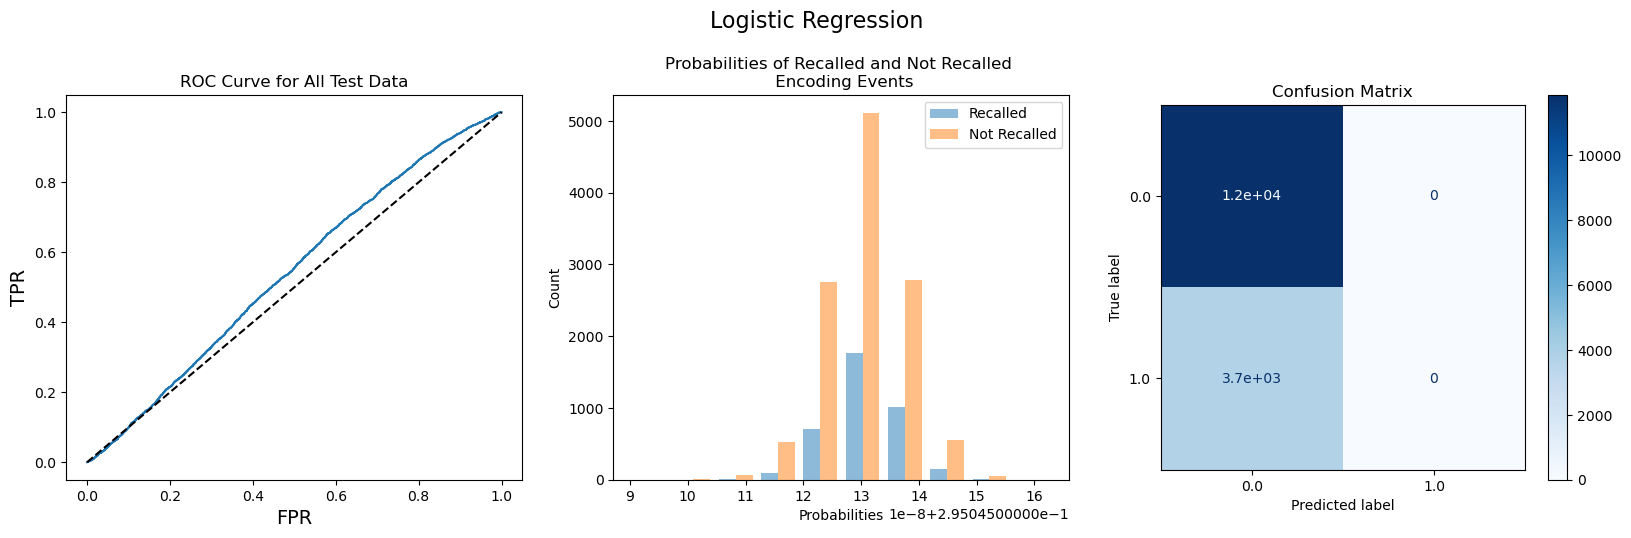

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     11857
         1.0       0.00      0.00      0.00      3747

    accuracy                           0.76     15604
   macro avg       0.38      0.50      0.43     15604
weighted avg       0.58      0.76      0.66     15604



In [139]:
logreg = LogisticRegression(C=7.742636826811278e-12, penalty='l2')
graph_results(logreg, "Logistic Regression", X, y, X_test, y_test)

Subject t-statistic: 4.8090193008488695
Subject p-value: 7.495019224131463e-05
Random fold t-statistic: 6.706908613721958
Random fold p-value: 7.670564579599447e-07


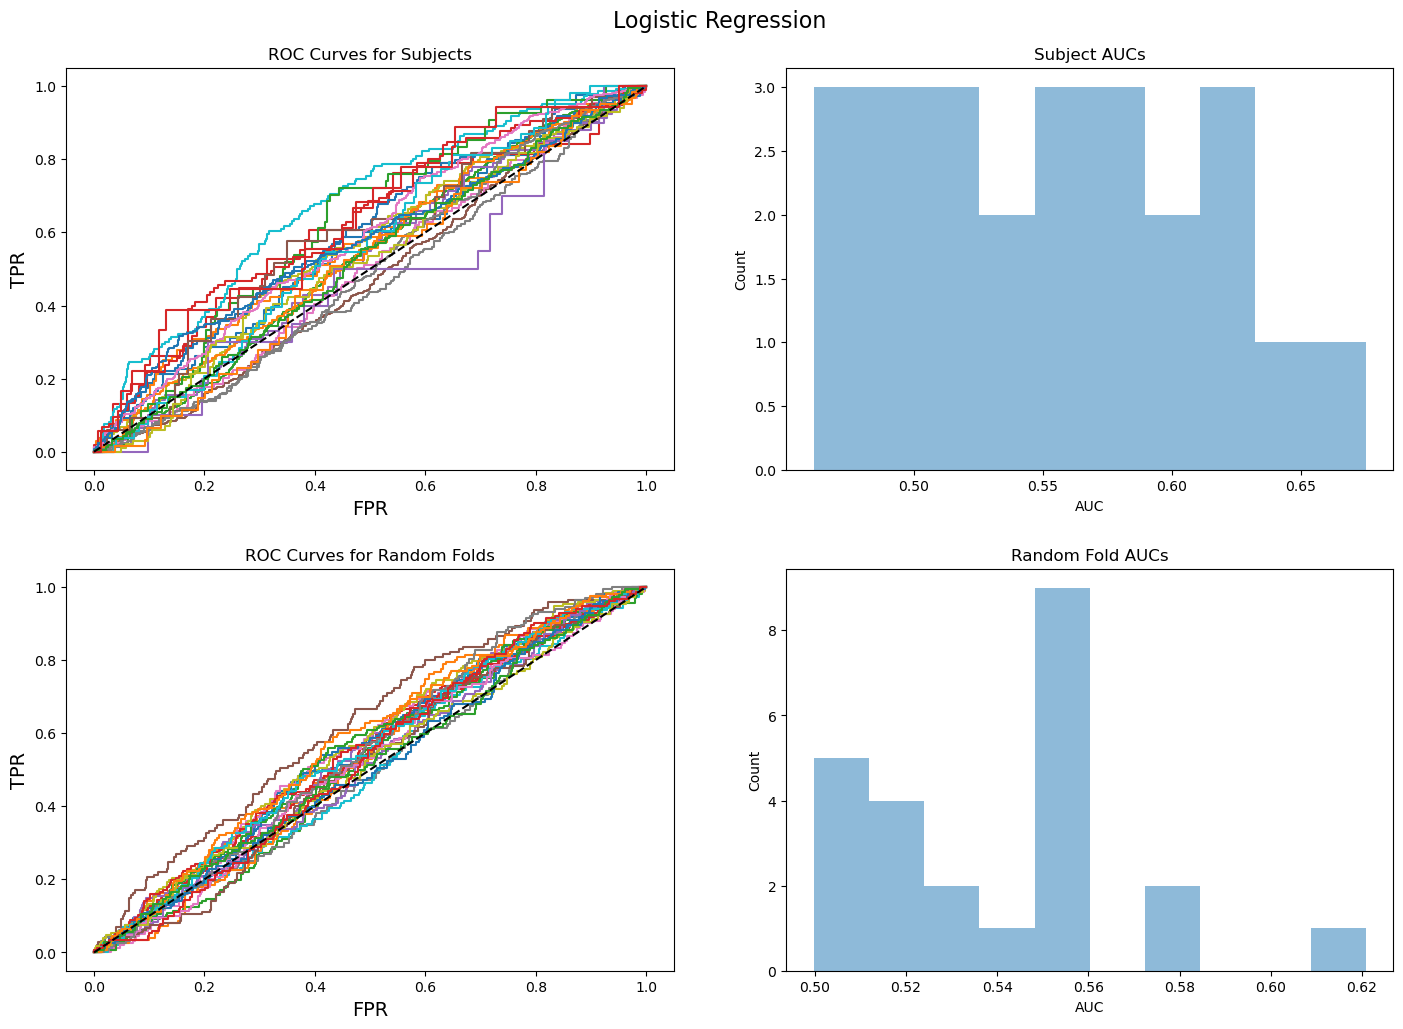

In [140]:
graph_stat_significance(logreg, "Logistic Regression", X, y, test_subs)

### Decision Tree

In [342]:
destree = DecisionTreeClassifier(random_state=123)
parameters =  {
    'min_samples_leaf': [0, 1, 2, 3, 4],
    'max_depth': [1, 2, 3, 4]
}
run_grid_search(destree, parameters, X, y, cv=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.8s finished


Best AUC value: 0.5230236724931159
Best params: {'max_depth': 3, 'min_samples_leaf': 1}


AUC: 0.5123212117246579
Accuracy: 0.7598692642912074


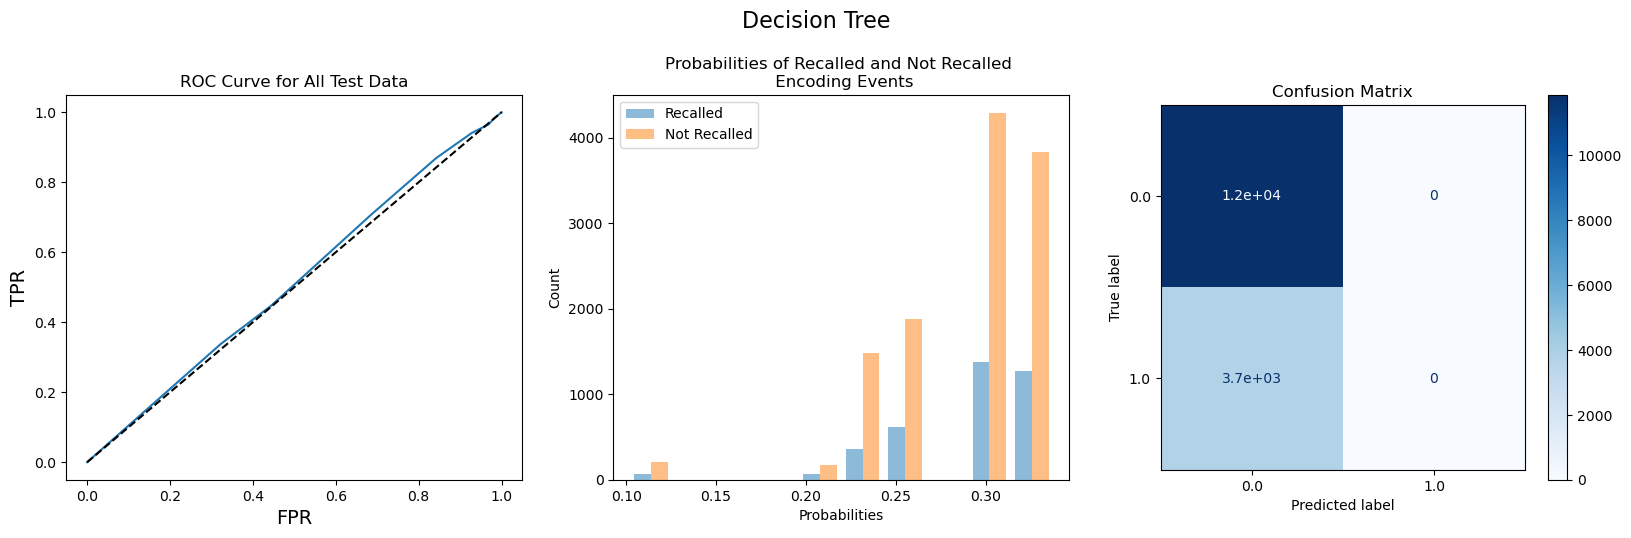

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     11857
         1.0       0.00      0.00      0.00      3747

    accuracy                           0.76     15604
   macro avg       0.38      0.50      0.43     15604
weighted avg       0.58      0.76      0.66     15604



In [96]:
destree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 1)
graph_results(destree, "Decision Tree", X, y, X_test, y_test)

Subject t-statistic: 2.075340167835281
Subject p-value: 0.04932352722610111
Random fold t-statistic: 2.185997538339762
Random fold p-value: 0.03880433810412483


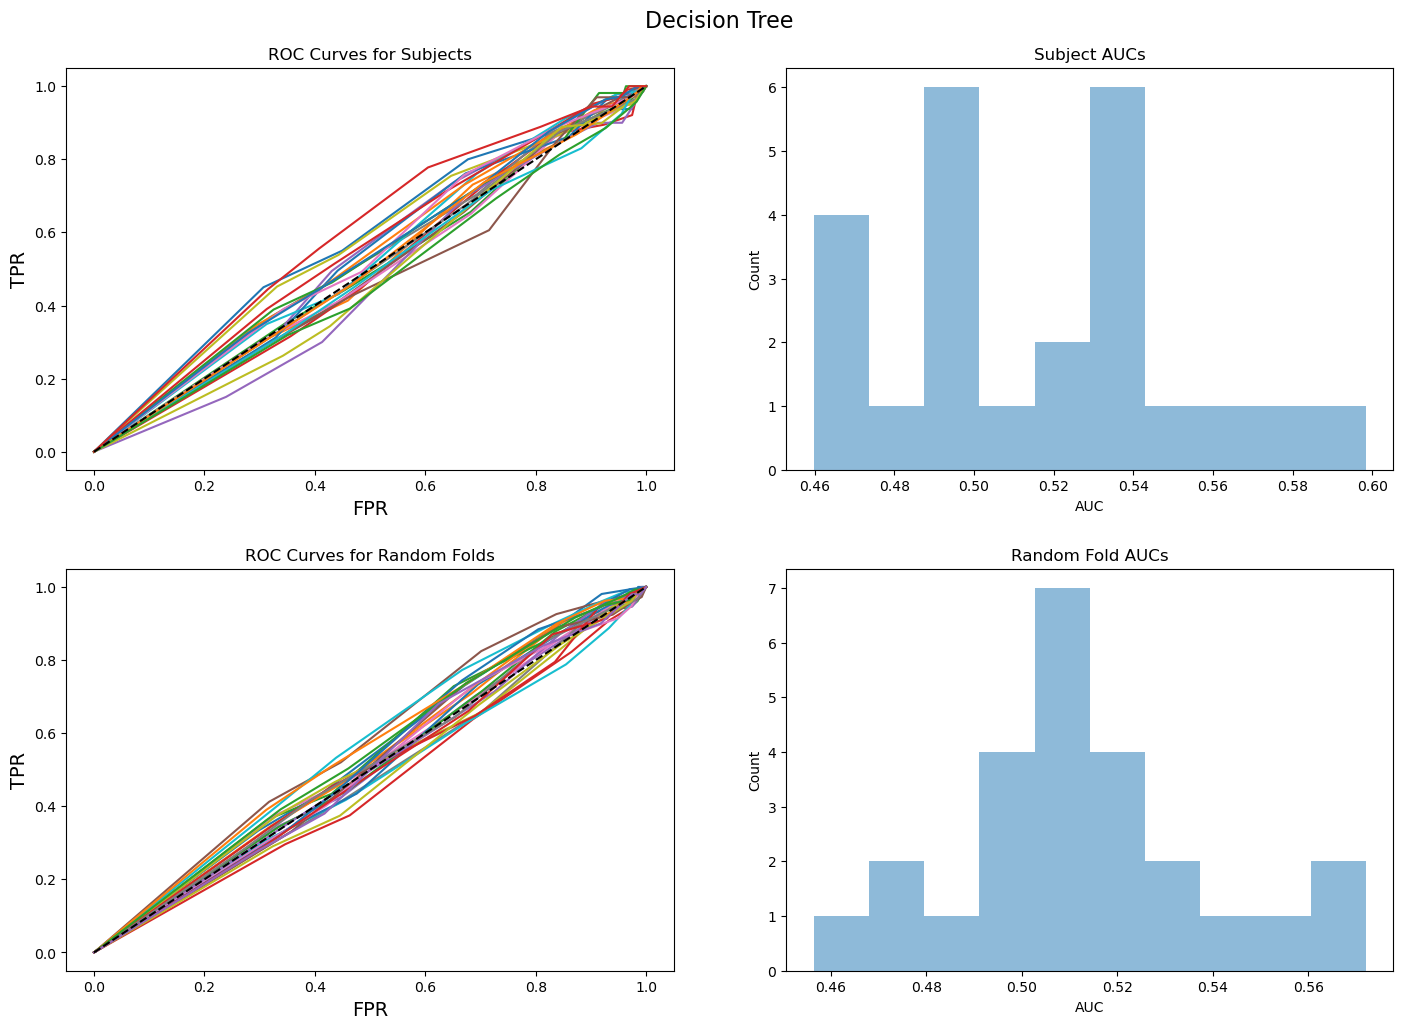

In [97]:
graph_stat_significance(destree, "Decision Tree", X, y, test_subs)

### KNN

In [343]:
knn = KNeighborsClassifier()
k_range = list(range(5, 10))
parameters = dict(n_neighbors=k_range)
run_grid_search(knn, parameters, X, y, cv=50)

Fitting 50 folds for each of 5 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.0min finished


Best AUC value: 0.48782094806723747
Best params: {'n_neighbors': 7}


AUC: 0.5025259981958748
Accuracy: 0.6632914637272495


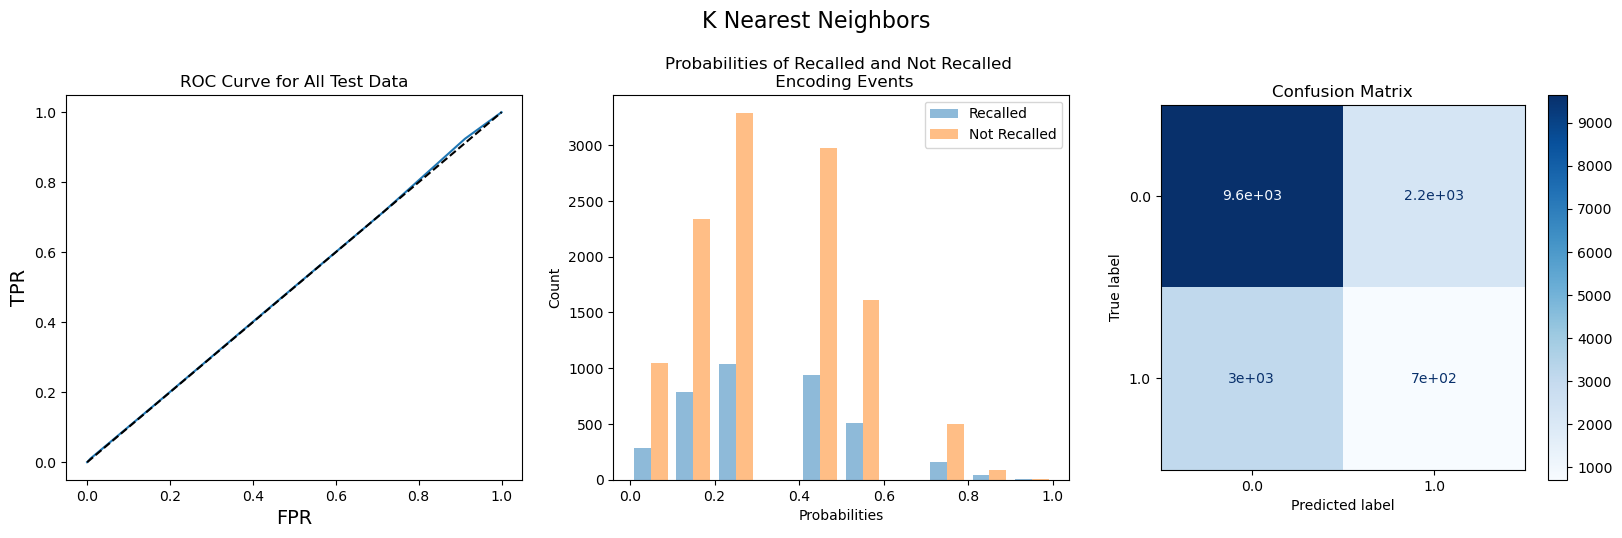

              precision    recall  f1-score   support

         0.0       0.76      0.81      0.79     11857
         1.0       0.24      0.19      0.21      3747

    accuracy                           0.66     15604
   macro avg       0.50      0.50      0.50     15604
weighted avg       0.64      0.66      0.65     15604



In [98]:
knn = KNeighborsClassifier(n_neighbors=7)
graph_results(knn, "K Nearest Neighbors", X, y, X_test, y_test)

Subject t-statistic: -1.2027377083274842
Subject p-value: 0.24131355445825264
Random fold t-statistic: 0.30654860660083416
Random fold p-value: 0.7618307312974647


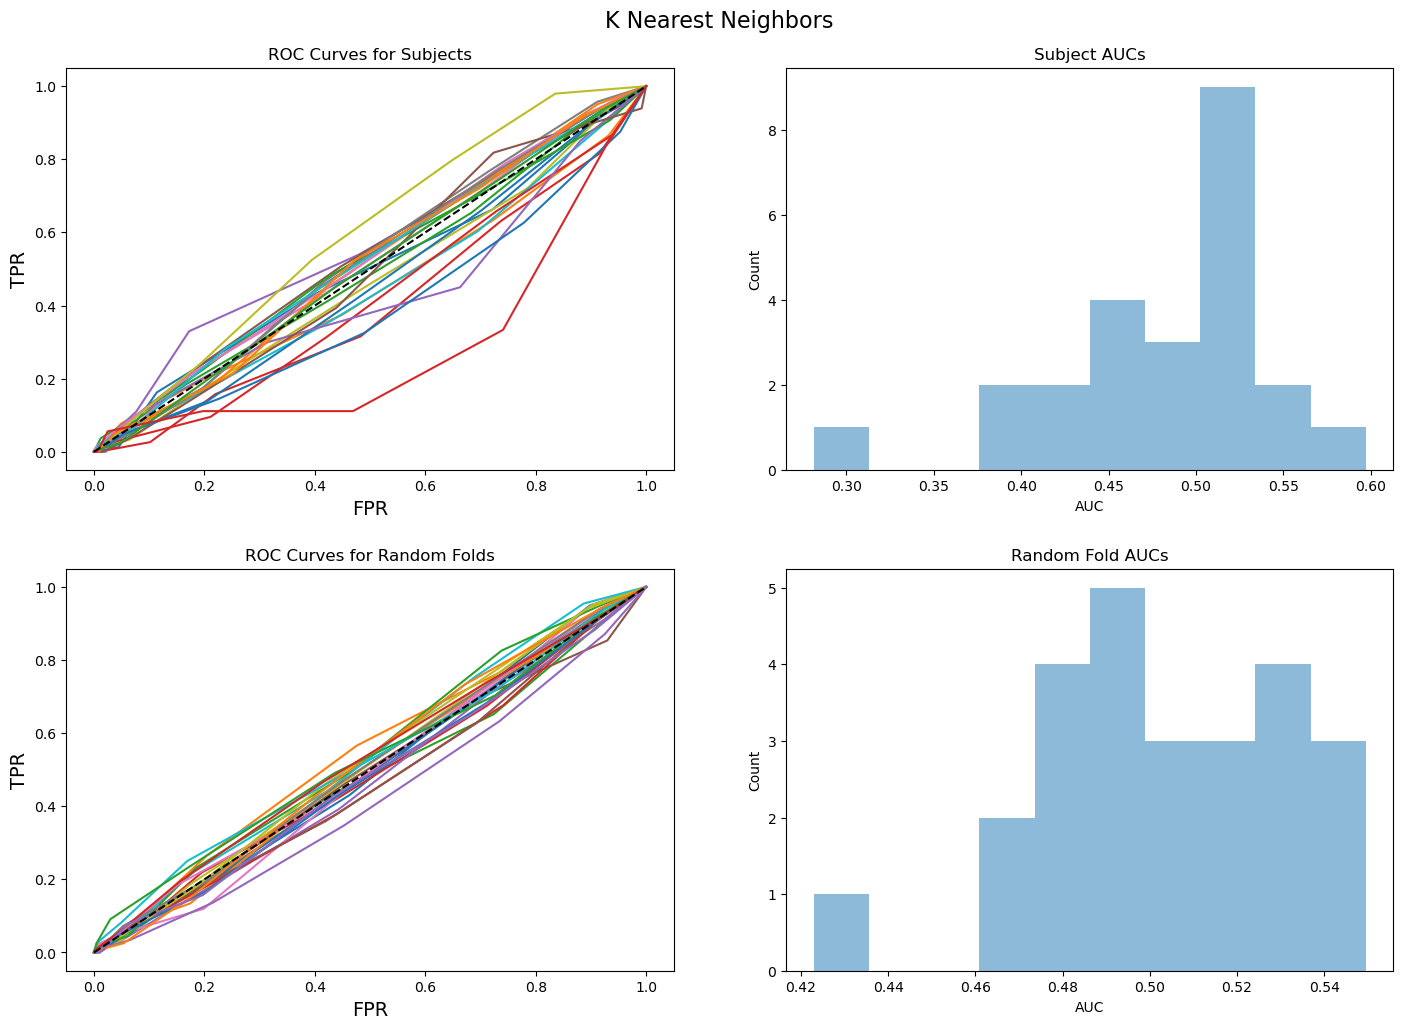

In [99]:
graph_stat_significance(knn, "K Nearest Neighbors", X, y, test_subs)

### Gaussian Bayes

In [344]:
nb = GaussianNB()
parameters = {
    'var_smoothing': np.logspace(-10, 0, num=100)
}
run_grid_search(nb, parameters, X, y, cv=50)

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2260 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 4660 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 4921 out of 5000 | elapsed:   26.4s remaining:    0.4s


Best AUC value: 0.536673348044443
Best params: {'var_smoothing': 0.0005857020818056661}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   26.7s finished


AUC: 0.5487690143681108
Accuracy: 0.6163163291463727


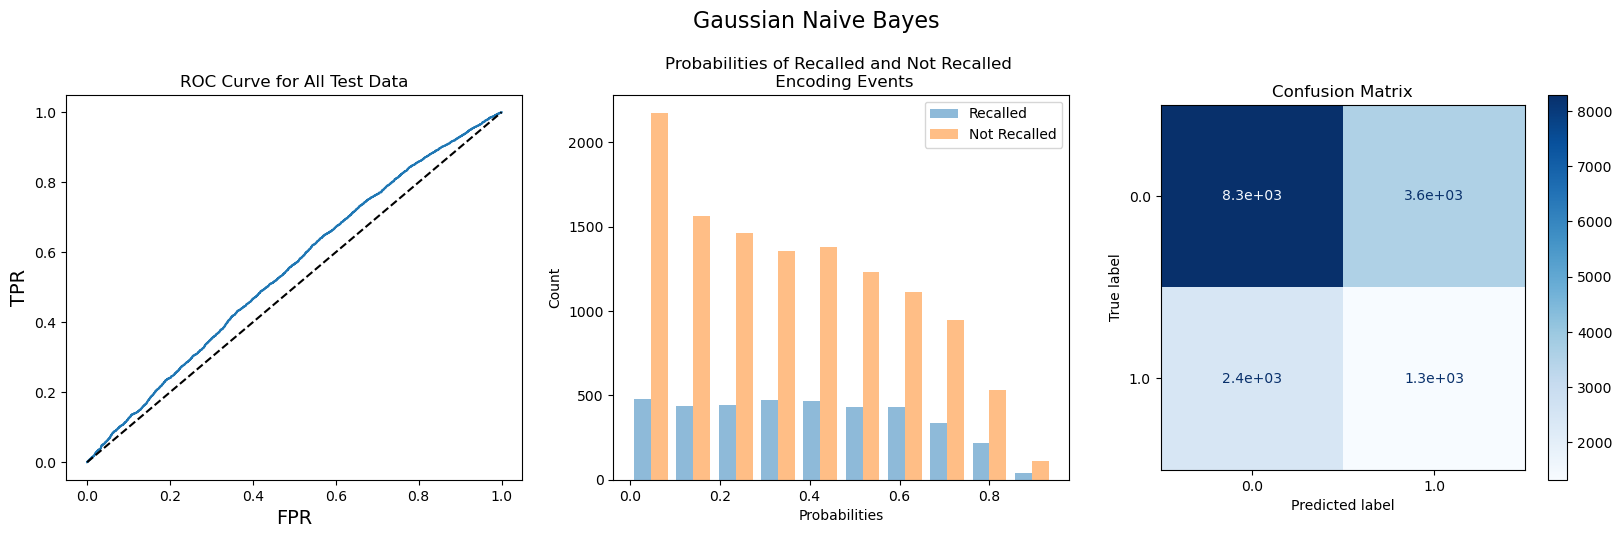

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73     11857
         1.0       0.27      0.35      0.31      3747

    accuracy                           0.62     15604
   macro avg       0.52      0.53      0.52     15604
weighted avg       0.65      0.62      0.63     15604



In [100]:
nb = GaussianNB(var_smoothing=0.0005857020818056661)
graph_results(nb, "Gaussian Naive Bayes", X, y, X_test, y_test)

Subject t-statistic: 6.164746753190053
Subject p-value: 2.737644397028135e-06
Random fold t-statistic: 9.929261287854713
Random fold p-value: 5.645533614051891e-10


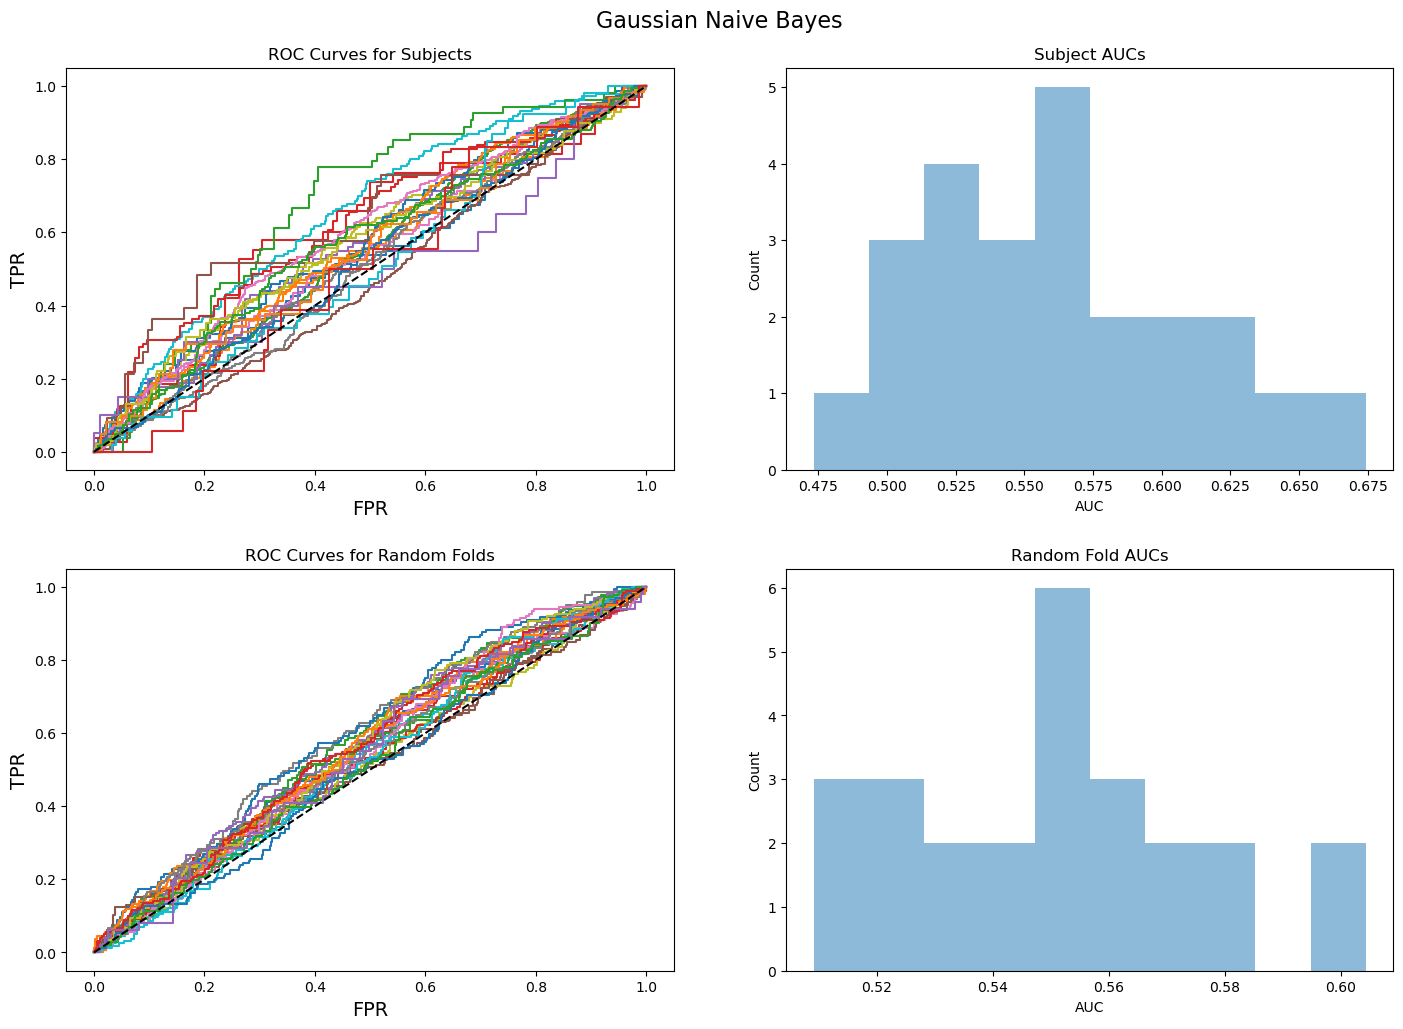

In [101]:
graph_stat_significance(nb, "Gaussian Naive Bayes", X, y, test_subs)

## Subjects with more electrodes

Even though the AUC values for Logistic Regression and Gaussian Naive Bayes were above .5 and statistically significant, all of the models’ AUC values were quite low. Given that we had optimized the model parameters, performance improvements could likely only come from improving our dataset features. We initially had 48 subjects and included 16 electrodes from their temporal lobe, 8 from their frontal lobe, and 2 from their hippocampal location. However, given that most subjects have far more than 26 electrodes taking scalp readings during these free recall experiments, our training (and testing) data did not include many potentially key features/EEG readings.

To address this, we want to include more electrodes from each region. We performed the same investigation on subjects that had 24 electrodes on their temporal lobe, 16 on their frontal lobe, and 4 on their hippocampal location. This left us with 14 total subjects, 7 of which were concatenated into a training dataset and the other 7 were concatenated into a testing dataset. (Like before, the powers were z-scored for each subject.)

In [72]:
sub_electrode_count_df = pickle_load("sub_electrode_full_counts")
sub_electrode_count_df = sub_electrode_count_df.loc[~(sub_electrode_count_df==0).all(axis=1)]
sub_electrode_count_df = sub_electrode_count_df[sub_electrode_count_df["temporal"] > 24]
sub_electrode_count_df = sub_electrode_count_df[sub_electrode_count_df["frontal"] > 16]
sub_electrode_count_df = sub_electrode_count_df[sub_electrode_count_df["hippocampal"] > 4]
print("Number of subjects to split into testing and training: ", len(sub_electrode_count_df.index))
pickle_save('sub_electrode_counts_2', sub_electrode_count_df)

Number of subjects to split into testing and training:  14


### Split subjects into train and test

In [23]:
subs_df = pickle_load('sub_electrode_counts_2')
all_model_subs_2 = list(subs_df.index)

In [32]:
train_subs_2 = all_model_subs_2[::2]
test_subs_2 = all_model_subs_2[1::2]

# drop subjects that give errors upon loading
train_subs_2.remove("R1063C")
test_subs_2.remove("R1486J")

print("Training subjects: ", train_subs_2)
print("Testing subjects: ", test_subs_2)

Training subjects:  ['R1364C', 'R1646T', 'R1415T', 'R1366J', 'R1157C', 'R1468J']
Testing subjects:  ['R1617S', 'R1372C', 'R1391T', 'R1573T', 'R1361C', 'R1473J']


### Generate Features

In [90]:
locations = ['temporal', 'frontal', 'hippocampal']
def generateFeatures(subj):
    logfile = f'{subj}_log.txt'
    subj_powers = []
    y_matrix = []

    df = get_data_index('all')
    df = df[(df['subject']==subj) & ((df['experiment']=='FR1') | (df['experiment']=='catFR1'))]

    for df_sess in df.itertuples():
        try:
            # prepare the reader and load EEG
            df_sess = df_sess._asdict()
            reader = CMLReader(df_sess['subject'], df_sess['experiment'], df_sess['session'], df_sess['montage'], df_sess['localization'])
            evs = reader.load('events')
            enc_evs = evs[evs.type=='WORD']
            scheme = reader.load('pairs')
            eeg = reader.load_eeg(events=enc_evs, rel_start=-1000, rel_stop=2600, clean=True, scheme=scheme)
            
            if len(eeg.events) != enc_evs.shape[0]:
                raise IndexError(str(len(eeg.events)) + ' eeg events for ' + str(enc_evs.shape[0]) + ' encoding events')
                
            sr = eeg.samplerate
            eeg_ptsa = eeg.to_ptsa()
            recalled_data = eeg_ptsa.event['recalled']
            y_matrix.extend(recalled_data)
            del eeg
            del recalled_data
            
            powers = []
            for loc_index in range(len(locations)):
                loc = locations[loc_index]
                loc_filter = [loc in s for s in [s if s else '' for s in scheme.iloc()[:]['ind.region']]]
                eeg_chan_loc = eeg_ptsa[:,loc_filter,:]

                freq_range = [58., 62.]
                b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter(eeg_chan_loc)
                del eeg_chan_loc

                freqs = (np.logspace(np.log10(3), np.log10(180),8))
                morlet_reps = 6
                wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, output='power', complete=True)
                powers_plusbuf = wf.filter(eeg_filtered)
                del eeg_filtered

                loc_powers = powers_plusbuf[:, :, :, int(sr):-1*int(sr)]
                del powers_plusbuf
                # only include 24 temporal electrodes, 16 frontal electrodes, and 4 hippocampal electrodes
                loc_powers = crop_loc_powers(loc_powers, loc, 24, 16, 4)
                powers.extend(loc_powers)

            powers = np.array(reshape_session_powers(powers))
            powers = np.log10(powers)
            powers = np.mean(powers, (3)) # average over time
            
            # zscore session
            powers = stats.zscore(powers, 1, ddof=1)
            subj_powers.append(powers)
            del powers
            
        except Exception as e:
            # Log the exception to a subject-labeled filename, along with a label of subject, experiment, and session.
            with open(logfile, 'a') as fw:
                date = datetime.datetime.now().strftime('%F_%H-%M-%S')
                sess = ""
                try:
                    sess = df_sess['session']
                except Exception as e:
                    sess = 'X'
                fw.write(f'{date}: {subj}, {sess}\n' +
                         ''.join(traceback.format_exception(type(e), e, e.__traceback__)))
                
    try:
        # save to a file
        matrix = np.array(reshape_subject_powers(subj_powers))
        np.savetxt(f'{subj}_X_2.txt', matrix)
        y_matrix = np.array(y_matrix)
        y_matrix = y_matrix[:, np.newaxis]
        np.savetxt(f'{subj}_y_2.txt', y_matrix)
        
    except Exception as e:
        with open(logfile, 'a') as fw:
                date = datetime.datetime.now().strftime('%F_%H-%M-%S')
                fw.write(f'{date}: {subj}\n' +
                         ''.join(traceback.format_exception(type(e), e, e.__traceback__)))

In [ ]:
# get all training subjects
missing_train_subs_2 = []
for sub in [sub for sub in train_subs_2]:
    try:
        np.loadtxt(f'{sub}_X_2.txt')
    except:
        missing_train_subs_2.append(sub)
print(missing_train_subs_2)

In [ ]:
client = da.new_dask_client("dask_client", "10GB", max_n_jobs=5)
futures = client.map(generateFeatures, missing_train_subs_2)

# Wait for results, check errors.
progress(futures)

In [94]:
# get all test subjects
missing_test_subs_2 = []
for sub in [sub for sub in test_subs_2]:
    try:
        np.loadtxt(f'{sub}_X_2.txt')
    except:
        missing_test_subs_2.append(sub)
print(missing_test_subs_2)

['R1617S', 'R1372C', 'R1391T', 'R1573T', 'R1486J', 'R1361C', 'R1473J']


In [95]:
client = da.new_dask_client("dask_client", "10GB", max_n_jobs=5)
futures = client.map(generateFeatures, missing_test_subs_2)

# Wait for results, check errors.
progress(futures)

Unique port for ziyaxu is 51537
{'dashboard_address': ':51537'}
To view the dashboard, run: 
`ssh -fN ziyaxu@rhino2.psych.upenn.edu -L 7000:192.168.86.125:45102` in your local computer's terminal (NOT rhino) 
and then navigate to http://localhost:7000 in your browser


VBox()

In [96]:
client.shutdown()

_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


#### Concatenate test and train data

In [98]:
X_frames = []
y_frames = []
for sub in train_subs_2:
    X = np.loadtxt(f'{sub}_X_2.txt')
    y = np.loadtxt(f'{sub}_y_2.txt')
    X_frames.append(X)
    y_frames.append(y)

X = np.concatenate(X_frames)
y = np.concatenate(y_frames)

np.savetxt('X_train_2.txt', X)
np.savetxt('y_train_2.txt', y)

In [99]:
X_frames = []
y_frames = []
for sub in test_subs_2:
    X = np.loadtxt(f'{sub}_X_2.txt')
    y = np.loadtxt(f'{sub}_y_2.txt')
    X_frames.append(X)
    y_frames.append(y)

X_test = np.concatenate(X_frames)
y_test = np.concatenate(y_frames)

np.savetxt('X_test_2.txt', X_test)
np.savetxt('y_test_2.txt', y_test)

### Finding the Best Model

In [141]:
X_2 = np.loadtxt('X_train_2.txt')
y_2 = np.loadtxt('y_train_2.txt')
X_test_2 = np.loadtxt('X_test_2.txt')
y_test_2 = np.loadtxt('y_test_2.txt')

#### Logistic Regression

In [19]:
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet'], 
    'C'       : np.logspace(-7,0,10),
}
logreg = LogisticRegression()
run_grid_search(logreg, parameters, X_2, y_2, cv=20)

Fitting 20 folds for each of 30 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s


Best AUC value: 0.5265321889053233
Best params: {'C': 0.0001291549665014884, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished


AUC: 0.5560427204363806
Accuracy: 0.67825


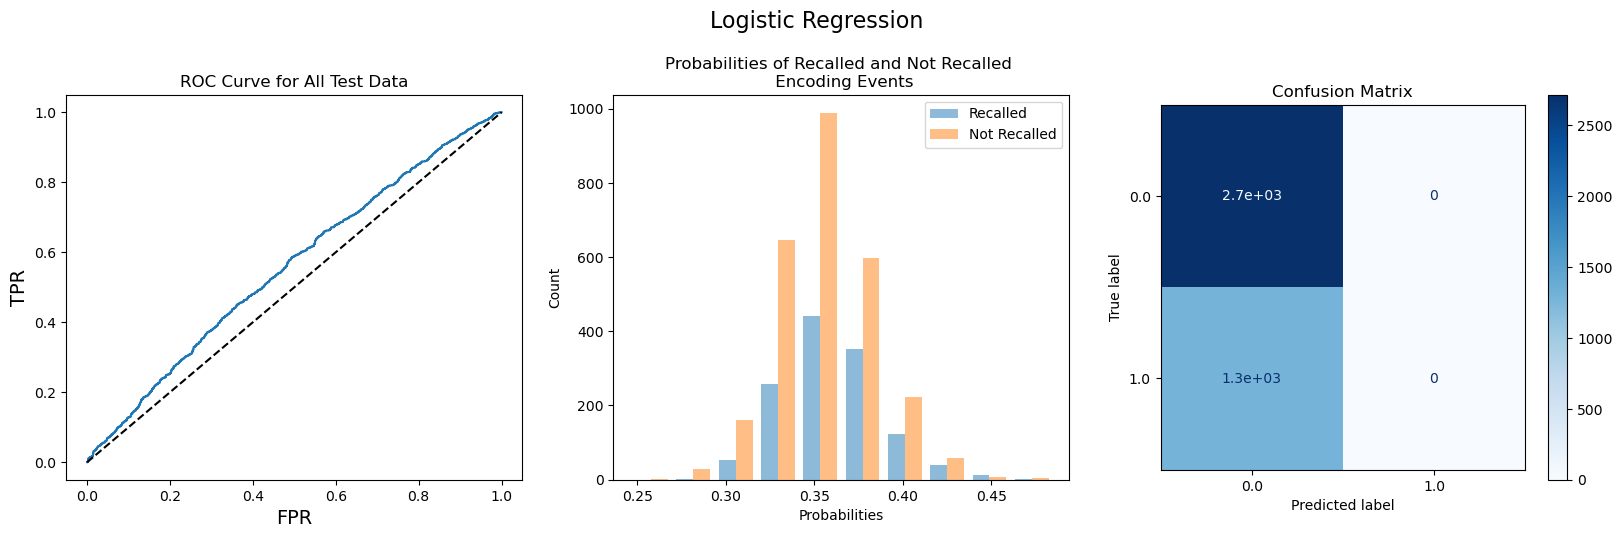

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81      2713
         1.0       0.00      0.00      0.00      1287

    accuracy                           0.68      4000
   macro avg       0.34      0.50      0.40      4000
weighted avg       0.46      0.68      0.55      4000



In [142]:
logreg = LogisticRegression(C=0.0001291549665014884, penalty='l2')
graph_results(logreg, "Logistic Regression", X_2, y_2, X_test_2, y_test_2)

Subject t-statistic: 1.3830486657389303
Subject p-value: 0.22522438104706485
Random fold t-statistic: 5.652789483325181
Random fold p-value: 9.379944991644186e-06


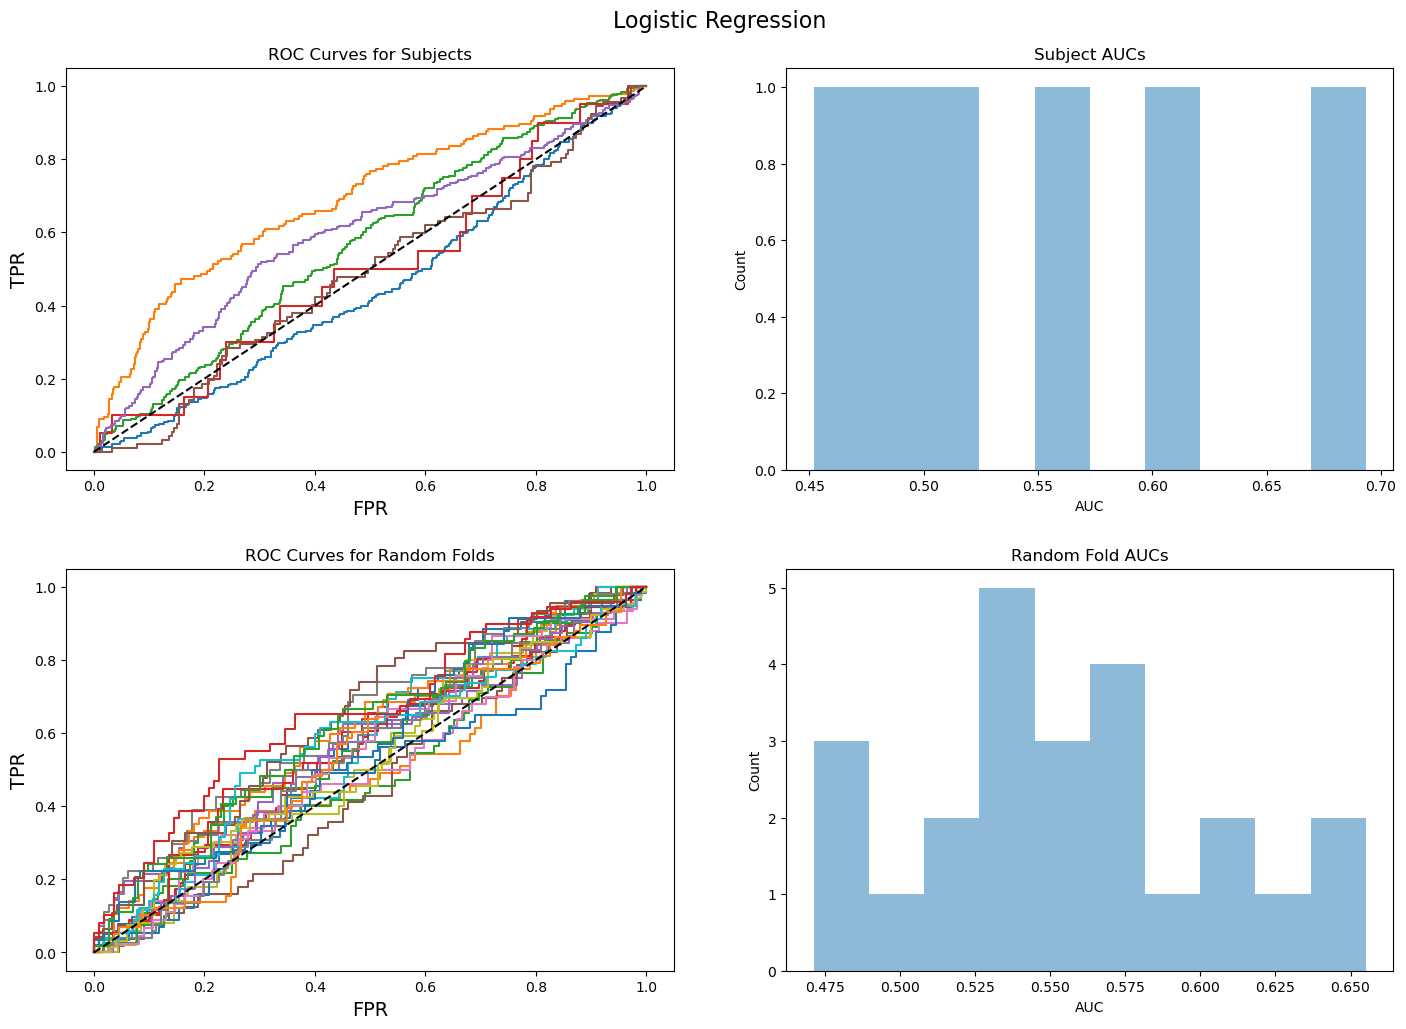

In [143]:
graph_stat_significance(logreg, "Logistic Regression", X_2, y_2, test_subs_2, more_electrodes=True)

#### Decision Tree

In [70]:
destree = DecisionTreeClassifier(random_state=123)
parameters =  {
    'min_samples_leaf': [0, 1, 2, 3, 4],
    'max_depth': [1, 2, 3, 4]
}
run_grid_search(destree, parameters, X_2, y_2, cv=20)

Fitting 20 folds for each of 20 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.3s finished


Best AUC value: 0.4971962933082336
Best params: {'max_depth': 2, 'min_samples_leaf': 1}


AUC: 0.5216075238190977
Accuracy: 0.6735


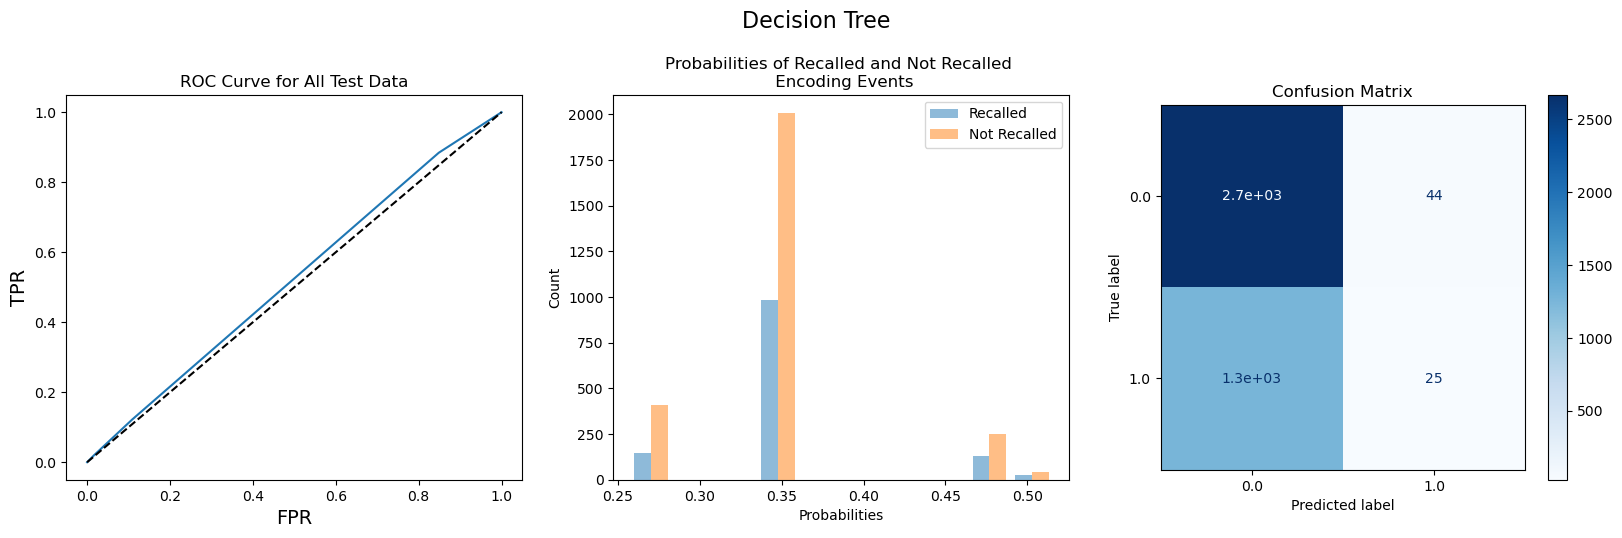

              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80      2713
         1.0       0.36      0.02      0.04      1287

    accuracy                           0.67      4000
   macro avg       0.52      0.50      0.42      4000
weighted avg       0.58      0.67      0.56      4000



In [144]:
destree = DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 1)
graph_results(destree, "Decision Tree", X_2, y_2, X_test_2, y_test_2)

Subject t-statistic: 1.1578569213330563
Subject p-value: 0.2992211894296508
Random fold t-statistic: 3.258964889452237
Random fold p-value: 0.0034547095774802787


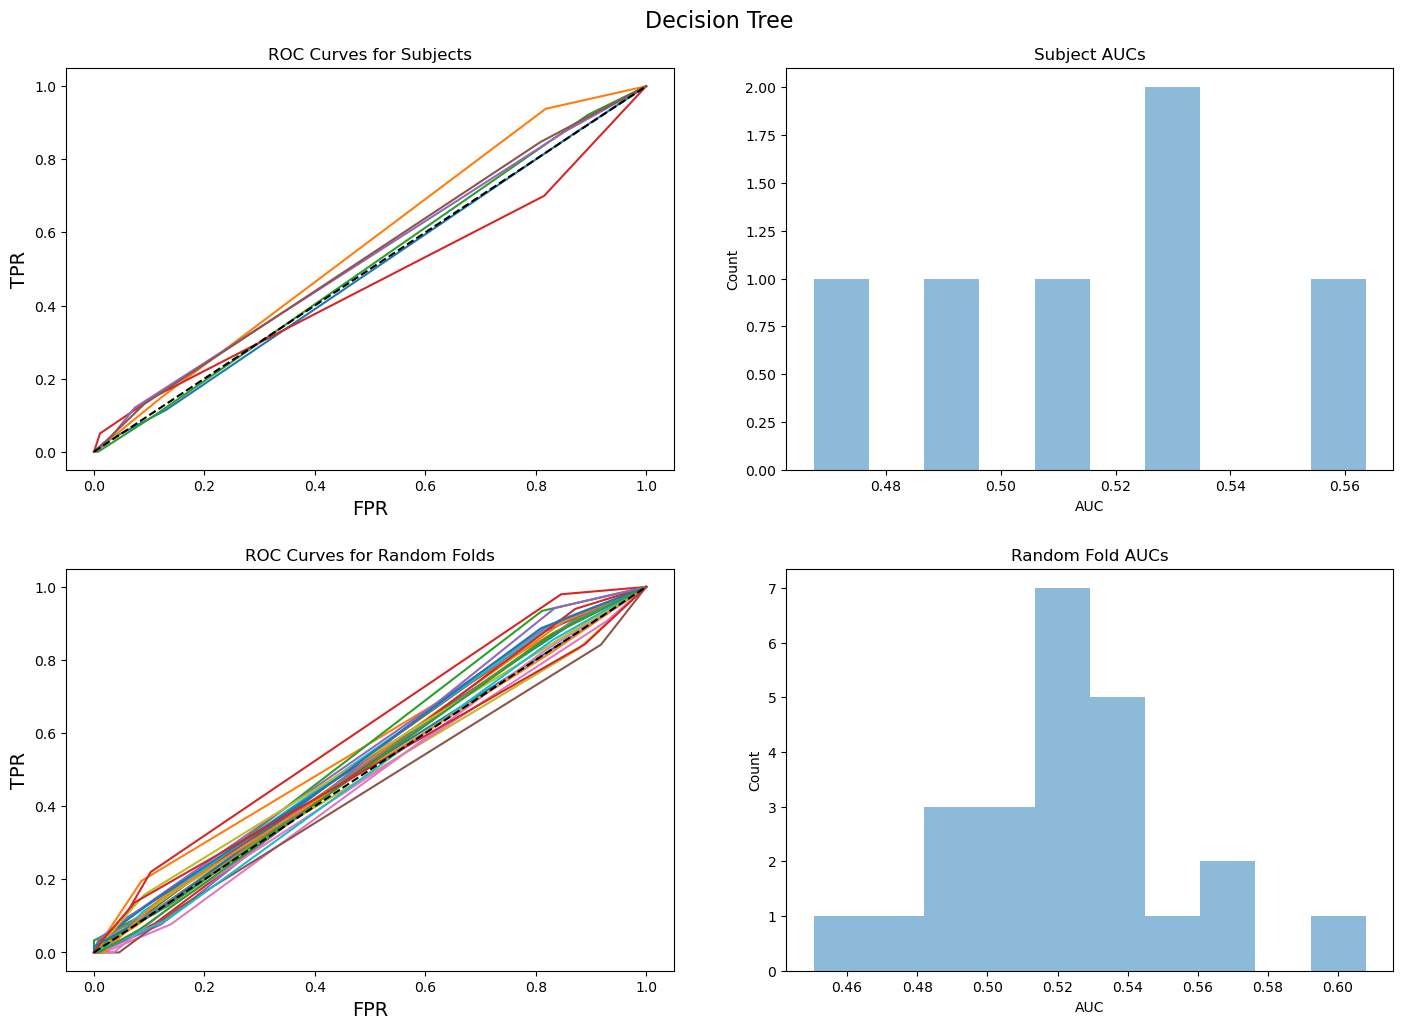

In [145]:
graph_stat_significance(destree, "Decision Tree", X_2, y_2, test_subs_2, more_electrodes=True)

#### KNN

In [74]:
knn = KNeighborsClassifier()
k_range = list(range(7, 12))
parameters = dict(n_neighbors=k_range)
run_grid_search(knn, parameters, X_2, y_2, cv=20)

Fitting 20 folds for each of 5 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Best AUC value: 0.5150773422676408
Best params: {'n_neighbors': 10}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


AUC: 0.5134644812123618
Accuracy: 0.67


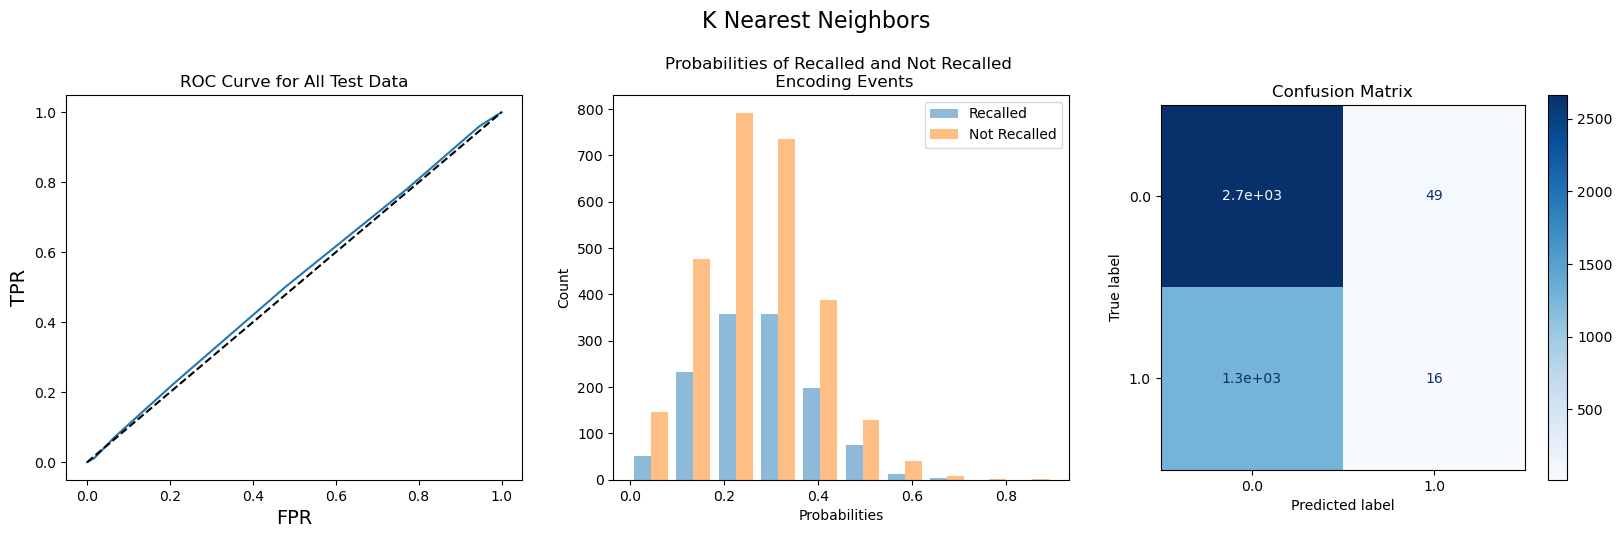

              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80      2713
         1.0       0.25      0.01      0.02      1287

    accuracy                           0.67      4000
   macro avg       0.46      0.50      0.41      4000
weighted avg       0.54      0.67      0.55      4000



In [146]:
knn = KNeighborsClassifier(n_neighbors=10)
graph_results(knn, "K Nearest Neighbors", X_2, y_2, X_test_2, y_test_2)

Subject t-statistic: 0.7553867150144808
Subject p-value: 0.4840605083996119
Random fold t-statistic: 1.262749554492109
Random fold p-value: 0.21933200506716144


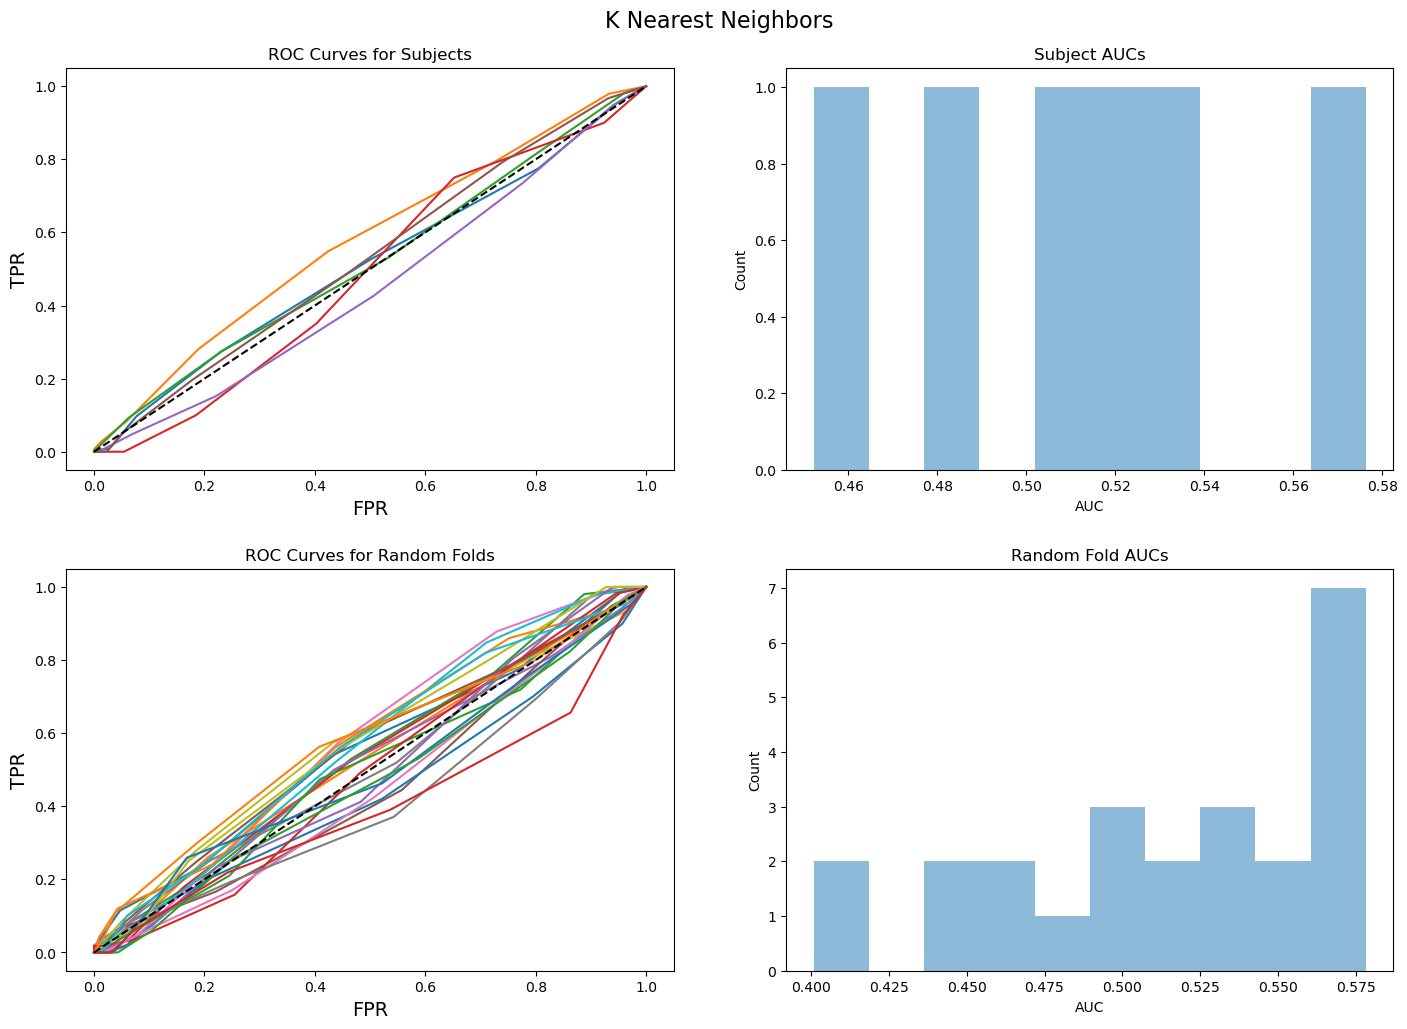

In [147]:
graph_stat_significance(knn, "K Nearest Neighbors", X_2, y_2, test_subs_2, more_electrodes=True)

#### Gaussian Bayes

In [77]:
nb = GaussianNB()
parameters = {
    'var_smoothing': np.logspace(-10, 0, num=100)
}
run_grid_search(nb, parameters, X_2, y_2, cv=20)

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:    5.4s


Best AUC value: 0.5309759983864462
Best params: {'var_smoothing': 0.0029836472402833404}


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    6.2s finished


AUC: 0.5695925485825966
Accuracy: 0.58225


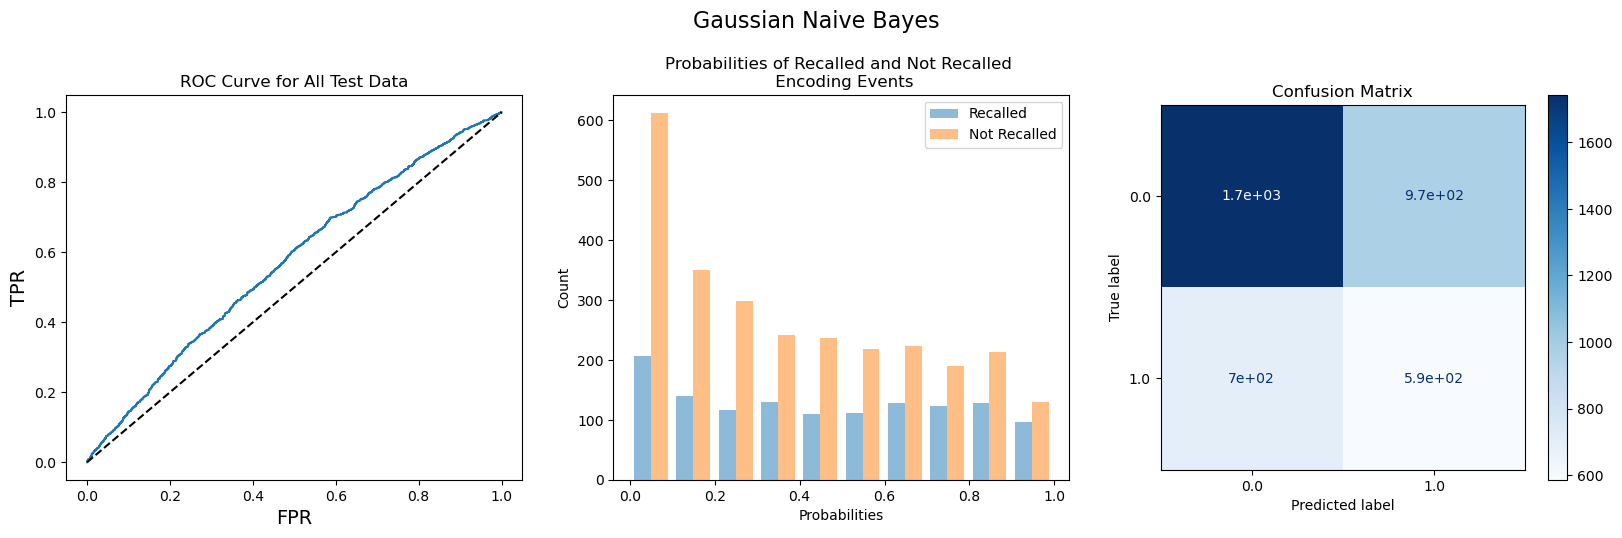

              precision    recall  f1-score   support

         0.0       0.71      0.64      0.68      2713
         1.0       0.38      0.46      0.41      1287

    accuracy                           0.58      4000
   macro avg       0.54      0.55      0.54      4000
weighted avg       0.60      0.58      0.59      4000



In [148]:
nb = GaussianNB(var_smoothing=0.0029836472402833404)
graph_results(nb, "Gaussian Naive Bayes", X_2, y_2, X_test_2, y_test_2)

Subject t-statistic: 2.4220688779115433
Subject p-value: 0.05996417783367262
Random fold t-statistic: 10.655719391070571
Random fold p-value: 2.2760250457200826e-10


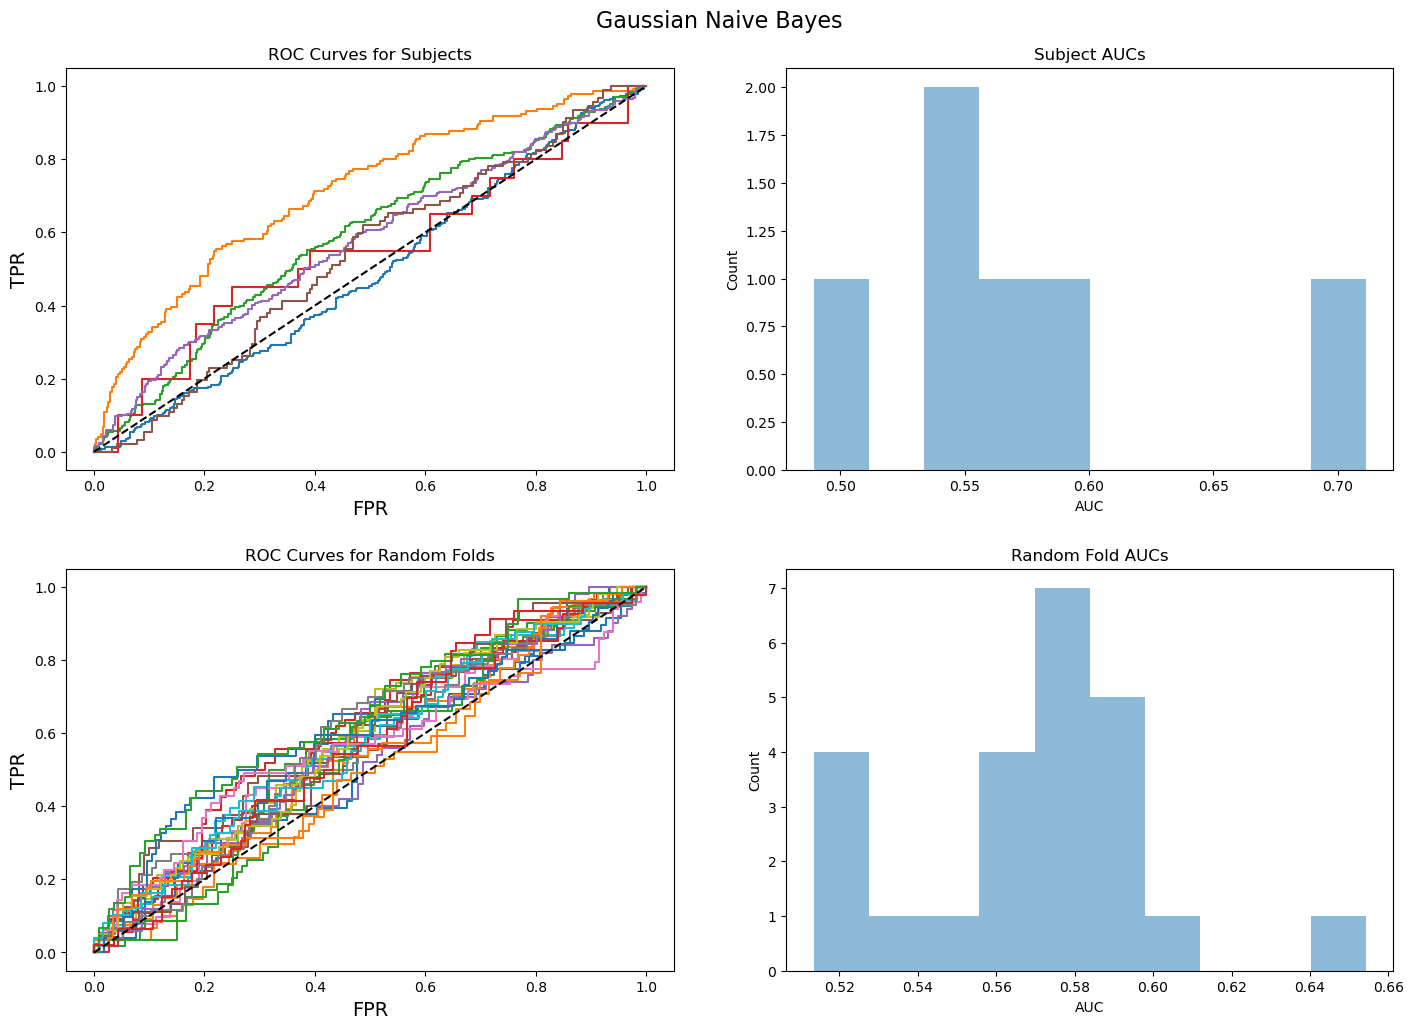

In [149]:
graph_stat_significance(nb, "Gaussian Naive Bayes", X_2, y_2, test_subs_2, more_electrodes=True)

## Individual Subject Models

We can compare the performance of these general models trained on various subjects to the performance of a subject-specific model. Since models that were trained on more features (24 temporal electrodes, 16 frontal electrodes, and 4 hippocampal electrodes vs. 16 temporal electrodes, 8 frontal electrodes, and 2 hippocampal electrodes) generally have higher AUC scores, we will look the 3 subjects with the most rows from the dataset with more features.

In [261]:
# find number of rows for each subject
for sub in [sub for sub in train_subs_2]:
    try:
        X = np.loadtxt(f'{sub}_X_2.txt')
        print(sub, X.shape)
    except:
        print(sub)

R1364C (816, 352)
R1646T (624, 352)
R1415T (624, 352)
R1366J (156, 352)
R1157C (900, 352)
R1468J (1056, 352)


### Graphing Function

In [247]:
def graph_random_folds(model, model_name, subject, X, y, X_test, y_test):
    model.fit(X, y)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{model_name} for {subject}', size=16, y=1)
    fig.tight_layout(h_pad=5, w_pad=5)
    
    auc_list = list()
    roc_list = list()

    len_test = len(y_test)
    num_columns = X_test.shape[1]
    
    y_test = y_test.reshape((-1, 1))
   
    # stack the data to randomize the order, randomize the rows, then resplit the data
    combined_test = np.hstack((X_test, y_test))
    np.random.shuffle(combined_test)

    # separate into into 16 random folds of data
    split_interval = int(math.ceil(len_test/16))
    splits = list(range(split_interval, len_test, split_interval))
    list_rand = np.vsplit(combined_test, splits)
    
    for data in list_rand:
        randomized = np.hsplit(data, np.array([num_columns]))
        X_test = randomized[0]
        y_test = randomized[1]
        y_test = y_test.reshape([len(y_test),])

        prob_array = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_array)

        roc_curve_data = roc_curve(y_test, prob_array)
        fpr = roc_curve_data[0]  # false positive rate
        tpr = roc_curve_data[1]  # true positive rate
        
        auc_list.append((auc))
        roc_list.append((tpr, fpr))
        
    aucs = np.array(auc_list)
    roc_curves = np.array(roc_list)
    
    # plot ROC curve
    ax[0].set_title('ROC Curves for Random Folds')
    ax[0].set_xlabel('FPR', fontsize=14)
    ax[0].set_ylabel('TPR', fontsize=14)
    for elem in roc_curves:
        ax[0].plot(elem[1], elem[0])
    ax[0].plot((0.0,1.0),(0.,1.), 'k--')
    
    # histogram of AUC
    ax[1].set_title('Random Fold AUCs')
    ax[1].set_xlabel('AUC')
    ax[1].set_ylabel('Count')
    ax[1].hist(aucs, alpha=0.5)
    
    tstat, pval = stats.ttest_1samp(auc_list, popmean=0.5)
    print("Random fold t-statistic:", tstat)
    print("Random fold p-value:", pval)
    
    plt.show()

### R1468J

In [248]:
curr_subject = 'R1468J'
X = np.loadtxt(f'{curr_subject}_X_2.txt')[::2, :]
y = np.loadtxt(f'{curr_subject}_y_2.txt')[::2]
X_test = np.loadtxt(f'{curr_subject}_X_2.txt')[1::2, :]
y_test = np.loadtxt(f'{curr_subject}_y_2.txt')[1::2]

In [249]:
logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet'], 
    'C'       : np.logspace(-10,5,10),
}
run_grid_search(logreg, parameters, X, y, cv=20)

Fitting 20 folds for each of 30 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.4s


Best AUC value: 0.577920751633987
Best params: {'C': 0.0004641588833612782, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 521 out of 600 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished


AUC: 0.5445284258954979
Accuracy: 0.678030303030303


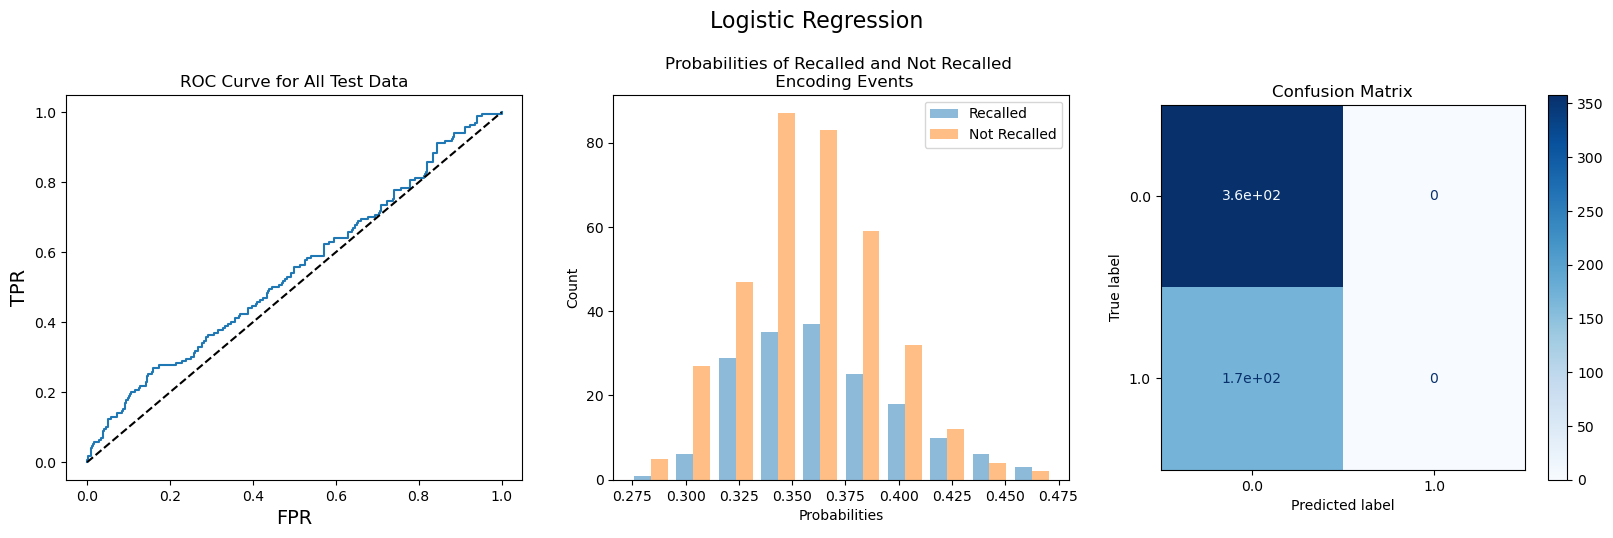

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81       358
         1.0       0.00      0.00      0.00       170

    accuracy                           0.68       528
   macro avg       0.34      0.50      0.40       528
weighted avg       0.46      0.68      0.55       528



In [250]:
logreg = LogisticRegression(C=0.0004641588833612782, penalty='l2')
graph_results(logreg, "Logistic Regression", X, y, X_test, y_test)

Random fold t-statistic: 0.7583943046479642
Random fold p-value: 0.45996590139473037


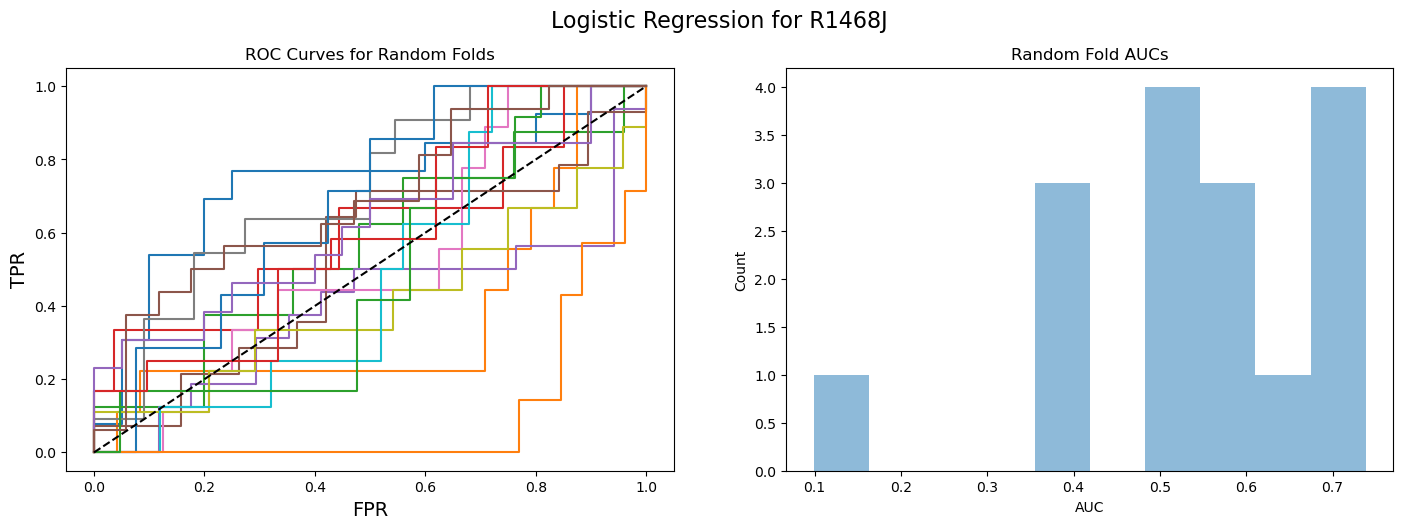

In [251]:
graph_random_folds(logreg, "Logistic Regression", curr_subject, X, y, X_test, y_test)

### R1157C

In [252]:
curr_subject = 'R1157C'
X = np.loadtxt(f'{curr_subject}_X_2.txt')[::2, :]
y = np.loadtxt(f'{curr_subject}_y_2.txt')[::2]
X_test = np.loadtxt(f'{curr_subject}_X_2.txt')[1::2, :]
y_test = np.loadtxt(f'{curr_subject}_y_2.txt')[1::2]

In [253]:
logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet'], 
    'C'       : np.logspace(-10,10,10),
}
run_grid_search(logreg, parameters, X, y, cv=20)

Fitting 20 folds for each of 30 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.4s


Best AUC value: 0.640297619047619
Best params: {'C': 0.0004641588833612782, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.8s finished


AUC: 0.6223283198100138
Accuracy: 0.7244444444444444


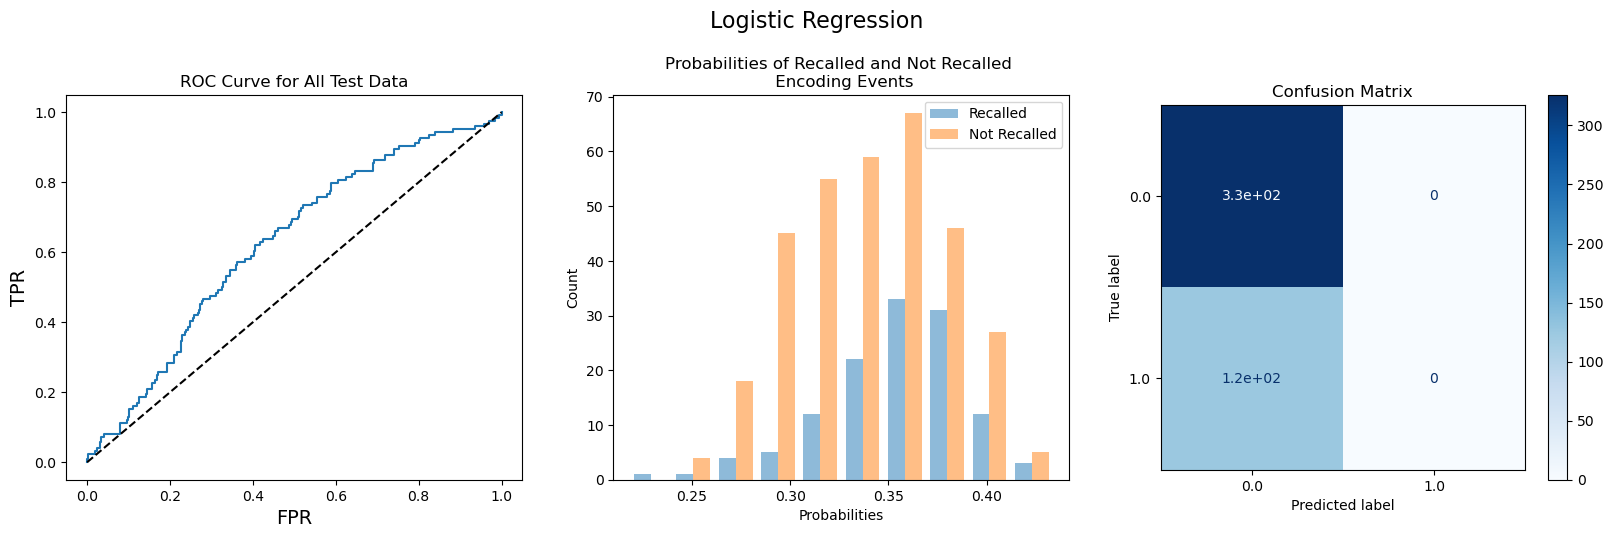

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       326
         1.0       0.00      0.00      0.00       124

    accuracy                           0.72       450
   macro avg       0.36      0.50      0.42       450
weighted avg       0.52      0.72      0.61       450



In [254]:
logreg = LogisticRegression(C=0.0004641588833612782, penalty='l2')
graph_results(logreg, "Logistic Regression", X, y, X_test, y_test)

Random fold t-statistic: 4.646307800511525
Random fold p-value: 0.0003165754878917765


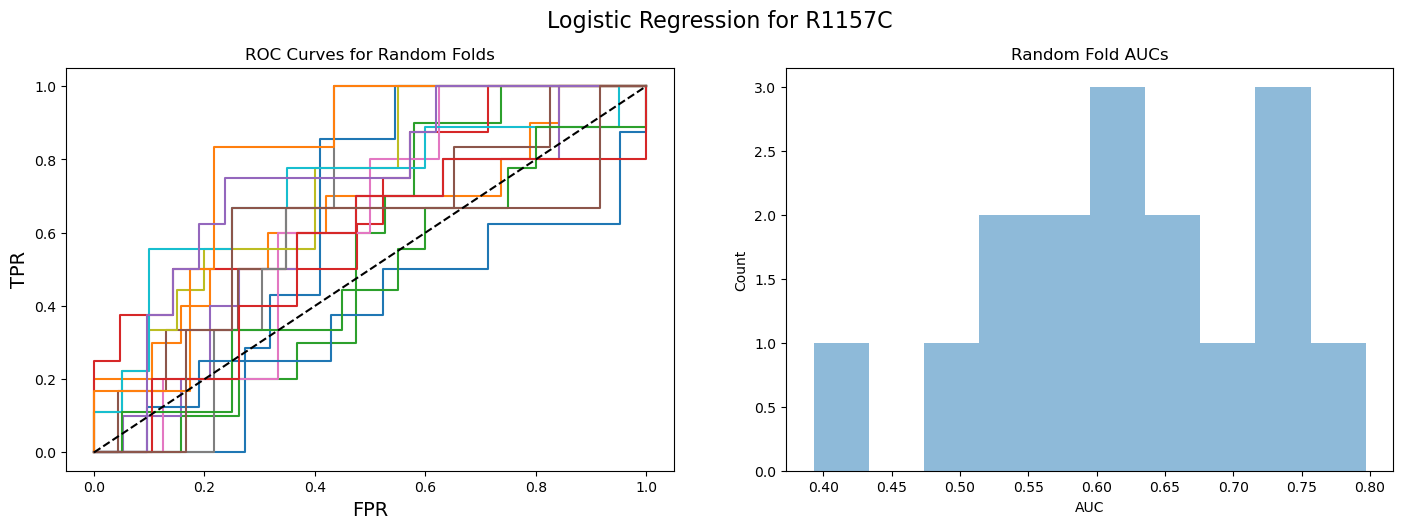

In [255]:
graph_random_folds(logreg, "Logistic Regression", curr_subject, X, y, X_test, y_test)

### R1364C

In [256]:
curr_subject = 'R1364C'
X = np.loadtxt(f'{curr_subject}_X_2.txt')[::2, :]
y = np.loadtxt(f'{curr_subject}_y_2.txt')[::2]
X_test = np.loadtxt(f'{curr_subject}_X_2.txt')[1::2, :]
y_test = np.loadtxt(f'{curr_subject}_y_2.txt')[1::2]

In [258]:
logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet'], 
    'C'       : np.logspace(-20,10,10),
}
run_grid_search(logreg, parameters, X, y, cv=20)

Fitting 20 folds for each of 30 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    0.5s


Best AUC value: 0.5300235478806907
Best params: {'C': 1e-10, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished


AUC: 0.5845248528859397
Accuracy: 0.6004901960784313


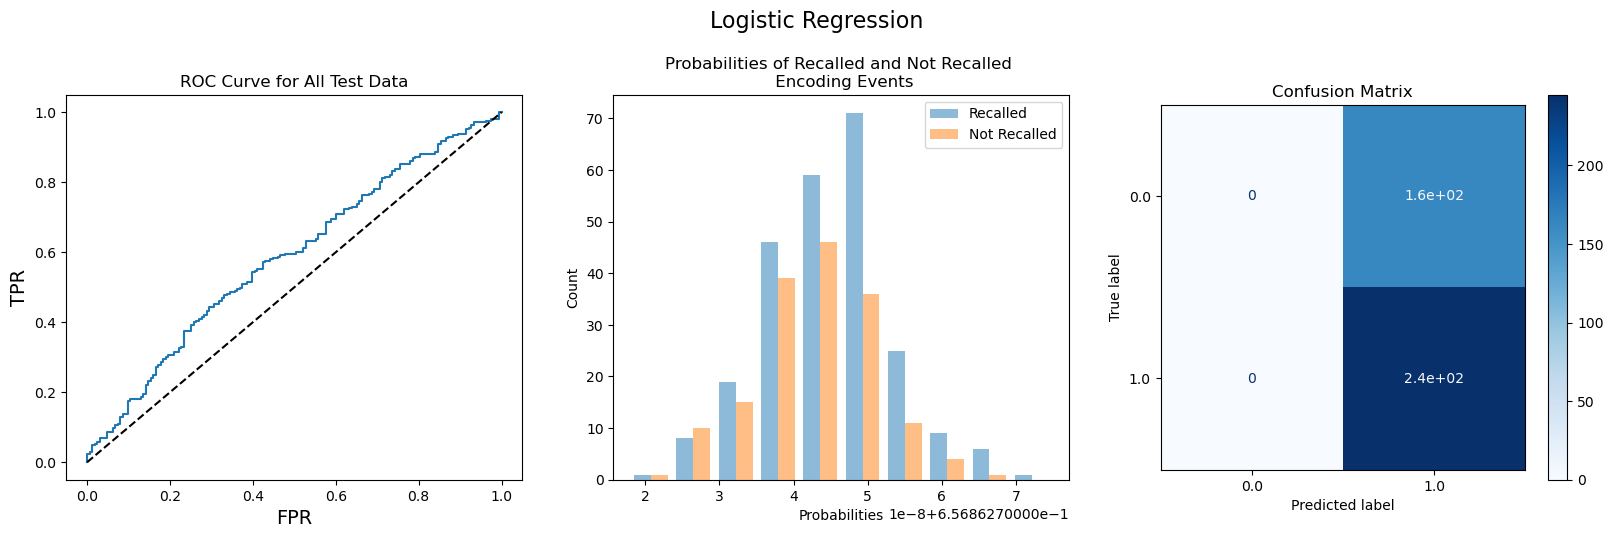

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       163
         1.0       0.60      1.00      0.75       245

    accuracy                           0.60       408
   macro avg       0.30      0.50      0.38       408
weighted avg       0.36      0.60      0.45       408



In [259]:
logreg = LogisticRegression(C=1e-10, penalty='l2')
graph_results(logreg, "Logistic Regression", X, y, X_test, y_test)

Random fold t-statistic: 3.597409706936951
Random fold p-value: 0.00263964556033099


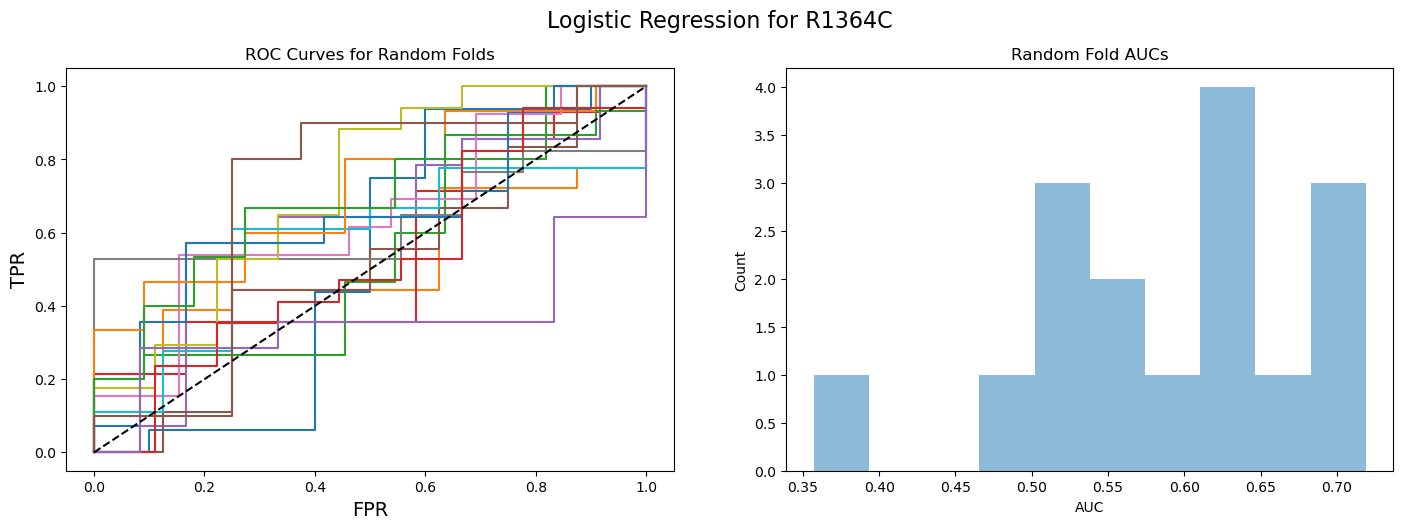

In [260]:
graph_random_folds(logreg, "Logistic Regression", curr_subject, X, y, X_test, y_test)